In [ ]:
# Define the path to the melt pool sizes data file
path = r'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Melt pool sizes.xlsx'

### Import packages

In [ ]:
import numpy as np
import pandas as pd
import random
# import seaborn
import copy
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import json

# Packages for processing and learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Packages for evaluation
# from numpy import mean
# from numpy import std
from scipy import stats
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from textwrap import wrap

# Models
import optuna
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
# Neural Network


# Sensitivity Analysis
import math
# from SALib.analyze import rbd_fast
from SALib.sample.sobol import sample as ss
from SALib.analyze.sobol import analyze as sa

seed = 42
from matplotlib import rc,rcParams
rc('font', weight='bold')

# Change cell width to fullscreen (like colab)
# https://stackoverflow.com/questions/21971449/how-do-i-increase-the-cell-width-of-the-jupyter-ipython-notebook-in-my-browser
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))

/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def OHEncoder_Func(data_input, column):
    '''OneHotEncoder - Encodes and replaces new encoded data to given dataframe'''
    # Extract the categorical columns
    df_categorical = data_input[column].to_frame()
    # Fit and transform the data
    encoder = OneHotEncoder()
    encoded_data = encoder.fit_transform(df_categorical)
    # Ensure categorical columns are of type object or categorical
    df_categorical = df_categorical.astype('category')
    # Get feature names and remove the prefix from feature names
    feature_names = encoder.get_feature_names_out(df_categorical.columns)
    feature_names = [name.split('_')[-1] for name in feature_names]
    # Store in dataframe with encoded data and feature names
    encoded_data = pd.DataFrame(encoded_data.toarray(), columns=feature_names)
    encoded_data = pd.concat([data_input, encoded_data], axis=1)
    # Drop the original columns that were one-hot encoded
    encoded_data.drop(column, axis=1, inplace=True)
    return encoded_data

In [3]:
def Standardizer_Func(data, features_list):
    '''Standardizes data and replaces the original values in the given dataframe'''

    # Standardize the features (mean=0 and variance=1)
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(data[features_list])
    # Replace original values with standardized values
    data[features_list] = x_scaled
    
    return data

In [4]:
def Preprocess_Func(f_path, in_var, out_var, mat_list):
    '''Reads data from file path and stores in dataframe for interested input, output features for ML and materials to filter dataframe.
       Uses temperature, time and pressure to predict (encompasses whether its AB, HT or HIP indirectly).'''
    
    dataset = pd.read_excel(f_path)
    column_names = dataset.columns
    variable_list = in_var + out_var

    column_names = dataset.columns
    # Change (um) to correct scientific symbol
    dataset.columns = [str.replace('(um)', '(\u03BCm)') for str in column_names]
    dataset = dataset.replace(r'/s+', np.nan, regex =True)

    # Searches selected variable's index number
    col_index = []
    for i in range(len(variable_list)): 
        col_index.append(column_names.get_loc(variable_list[i]))
    # Change (um) to correct scientific symbol
    variable_list = [str.replace('(um)', '(\u03BCm)') for str in variable_list]
    in_var = [str.replace('(um)', '(\u03BCm)') for str in in_var]
    out_var = [str.replace('(um)', '(\u03BCm)') for str in out_var]
    #col_index.append(column_names.get_loc(variable_list[i]))
    # Converts whole dataset to df and filters necessary columns 
    dataset = dataset[dataset.columns[col_index]]

    # Filter data to specified materials
    dataset = dataset[dataset['Material'].isin(mat_list)].reset_index(drop=True)

    # Encode materials data
    df_encoded = OHEncoder_Func(data_input=dataset, column='Material')
    x_df = df_encoded.drop(columns=out_var)
    y_df = df_encoded[out_var]

    return x_df, y_df

In [5]:
def Train_Test_Func(x_data, y_data, test_ratio=0.2):
    '''Splits train/test data and drops NaN per given output in y_data - maximises number of data to train/test'''

    train_data = []
    test_data = []

    for i in y_data.columns:
        # Create new dataframe for each output and drop data to maximise amount
        tmp_df = x_data.join(y_data[i]).dropna()

        # Train/Test to 80/20 split - no validation set as we will use CV
        X_train, X_test, y_train, y_test = train_test_split(tmp_df[x_data.columns], tmp_df[i].to_frame(), test_size=test_ratio, random_state=seed)

        train_data.append([X_train, y_train])
        test_data.append([X_test, y_test])

    for i in range(0, len(train_data)):
        variable = train_data[i][1].columns.to_list()[0]
        total_data = len(y_df)
        remain_data = len(train_data[i][0])
        dropped_data = total_data - remain_data
        print(" Variable: ", variable, "\n", "Total data = ", total_data, "\n", "Dropped data = ", dropped_data, "\n", "Remaining data = ", remain_data, "\n")

    # Scale inputs for training - keep non scaled too for visualisation
    train_data_scaled = copy.deepcopy(train_data)
    test_data_scaled = copy.deepcopy(test_data)
    input_params = copy.deepcopy(input_var)
    input_params.remove("Material")

    tmp = []
    for x,y in train_data_scaled:
        # Standardize the features (mean=0 and variance=1)
        x = Standardizer_Func(data=x, features_list=input_params)

    for x,y in test_data_scaled:
        # Standardize the features (mean=0 and variance=1)
        x = Standardizer_Func(data=x, features_list=input_params)

    return train_data, test_data, train_data_scaled, test_data_scaled

In [ ]:
# Choose materials and features input and outputs
materials_list = ['316L', 'Hastelloy X', 'Ti6Al4V', '718LC', 'CP Ti', 'AlSi10Mg', 'IN625', '904l', 'IN718']
input_var = ['Material',
             'Laser Power (W)',
             'Scanning Speed (mm/s)',
            #  'Layer Thickness (um)',
            #  'Hatch Spacing (um)',
            #  'Beam Size (um)'
             ]

output_var = ['Width (um)',
              'Height (um)',
              'Depth (um)']

# Save Author and year as list for plotting
dataset = pd.read_excel(path)
authors_list = dataset['Authors']
dataset['Year'].fillna(method='ffill', inplace=True)
year_list = dataset['Year']
author_list = [author  + ", " + str(year) for author, year in zip(authors_list, year_list)]
unique_authors = list(set(author_list))
# Read and filter data based on inputs, outputs and materials
x_df, y_df = Preprocess_Func(f_path=path, in_var=input_var, out_var=output_var, mat_list=materials_list)
# Store train/test data and drop NaN values for each output individually
train_df, test_df, train_scaled, test_scaled = Train_Test_Func(x_data=x_df, y_data=y_df, test_ratio=0.2)

 Variable:  Width (μm) 
 Total data =  522 
 Dropped data =  181 
 Remaining data =  341 

 Variable:  Height (μm) 
 Total data =  522 
 Dropped data =  376 
 Remaining data =  146 

 Variable:  Depth (μm) 
 Total data =  522 
 Dropped data =  270 
 Remaining data =  252 



/var/folders/dr/88_11bqj7nv1y6zj8hs35g3m0000gp/T/ipykernel_44313/3190464411.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset['Year'].fillna(method='ffill', inplace=True)
/var/folders/dr/88_11bqj7nv1y6zj8hs35g3m0000gp/T/ipykernel_44313/3190464411.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dataset['Year'].fillna(method='ffill', inplace=True)


In [7]:
train_df[0][0]

Laser Power (W)  Scanning Speed (mm/s)  316L  718LC  904l  AlSi10Mg  \
66             160.0                    300   0.0    0.0   0.0       0.0   
132            208.0                    800   0.0    0.0   0.0       1.0   
287             50.0                    450   0.0    0.0   0.0       0.0   
31             100.0                    750   0.0    0.0   0.0       0.0   
84             300.0                    500   0.0    0.0   0.0       0.0   
..               ...                    ...   ...    ...   ...       ...   
71             160.0                    500   0.0    0.0   0.0       0.0   
106            400.0                    100   0.0    0.0   0.0       0.0   
338            140.0                    650   0.0    0.0   0.0       0.0   
427            290.0                   1000   0.0    0.0   0.0       0.0   
102            400.0                    225   0.0    0.0   0.0       0.0   

     CP Ti  Hastelloy X  IN625  IN718  Ti6Al4V  
66     1.0          0.0    0.0    0.0      0.0  
132    0.0          0.0    0.0    0.0      0.0  
287    0.0          0.0    0.0    1.0      0.0  
31     0.0          0.0    0.0    0.0      1.0  
84     0.0          0.0    0.0    0.0      1.0  
..     ...          ...    ...    ...      ...  
71     1.0          0.0    0.0    0.0      0.0  
106    0.0          0.0    0.0    0.0      1.0  
338    0.0          0.0    0.0    1.0      0.0  
427    0.0          0.0    0.0    1.0      0.0  
102    0.0          0.0    0.0    0.0      1.0  

[341 rows x 11 columns]

In [8]:
train_df[0][0]

Laser Power (W)  Scanning Speed (mm/s)  316L  718LC  904l  AlSi10Mg  \
66             160.0                    300   0.0    0.0   0.0       0.0   
132            208.0                    800   0.0    0.0   0.0       1.0   
287             50.0                    450   0.0    0.0   0.0       0.0   
31             100.0                    750   0.0    0.0   0.0       0.0   
84             300.0                    500   0.0    0.0   0.0       0.0   
..               ...                    ...   ...    ...   ...       ...   
71             160.0                    500   0.0    0.0   0.0       0.0   
106            400.0                    100   0.0    0.0   0.0       0.0   
338            140.0                    650   0.0    0.0   0.0       0.0   
427            290.0                   1000   0.0    0.0   0.0       0.0   
102            400.0                    225   0.0    0.0   0.0       0.0   

     CP Ti  Hastelloy X  IN625  IN718  Ti6Al4V  
66     1.0          0.0    0.0    0.0      0.0  
132    0.0          0.0    0.0    0.0      0.0  
287    0.0          0.0    0.0    1.0      0.0  
31     0.0          0.0    0.0    0.0      1.0  
84     0.0          0.0    0.0    0.0      1.0  
..     ...          ...    ...    ...      ...  
71     1.0          0.0    0.0    0.0      0.0  
106    0.0          0.0    0.0    0.0      1.0  
338    0.0          0.0    0.0    1.0      0.0  
427    0.0          0.0    0.0    1.0      0.0  
102    0.0          0.0    0.0    0.0      1.0  

[341 rows x 11 columns]

In [9]:
train_scaled[0][0]

Laser Power (W)  Scanning Speed (mm/s)  316L  718LC  904l  AlSi10Mg  \
66         -0.663151              -0.886206   0.0    0.0   0.0       0.0   
132        -0.263315               0.109827   0.0    0.0   0.0       1.0   
287        -1.579440              -0.587397   0.0    0.0   0.0       0.0   
31         -1.162945               0.010223   0.0    0.0   0.0       0.0   
84          0.503036              -0.487793   0.0    0.0   0.0       0.0   
..               ...                    ...   ...    ...   ...       ...   
71         -0.663151              -0.487793   0.0    0.0   0.0       0.0   
106         1.336026              -1.284620   0.0    0.0   0.0       0.0   
338        -0.829749              -0.188983   0.0    0.0   0.0       0.0   
427         0.419737               0.508240   0.0    0.0   0.0       0.0   
102         1.336026              -1.035611   0.0    0.0   0.0       0.0   

     CP Ti  Hastelloy X  IN625  IN718  Ti6Al4V  
66     1.0          0.0    0.0    0.0      0.0  
132    0.0          0.0    0.0    0.0      0.0  
287    0.0          0.0    0.0    1.0      0.0  
31     0.0          0.0    0.0    0.0      1.0  
84     0.0          0.0    0.0    0.0      1.0  
..     ...          ...    ...    ...      ...  
71     1.0          0.0    0.0    0.0      0.0  
106    0.0          0.0    0.0    0.0      1.0  
338    0.0          0.0    0.0    1.0      0.0  
427    0.0          0.0    0.0    1.0      0.0  
102    0.0          0.0    0.0    0.0      1.0  

[341 rows x 11 columns]

In [10]:
test_scaled[1][0].head()

Laser Power (W)  Scanning Speed (mm/s)  316L  718LC  904l  AlSi10Mg  \
58         -0.951660              -1.624217   0.0    0.0   0.0       0.0   
81          2.278745              -1.624217   0.0    0.0   0.0       0.0   
399        -0.197899               1.125274   0.0    0.0   0.0       0.0   
349        -0.843979               0.339705   0.0    0.0   0.0       0.0   
389         0.448182               0.928882   0.0    0.0   0.0       0.0   

     CP Ti  Hastelloy X  IN625  IN718  Ti6Al4V  
58     1.0          0.0    0.0    0.0      0.0  
81     0.0          0.0    0.0    0.0      1.0  
399    0.0          0.0    0.0    1.0      0.0  
349    0.0          0.0    0.0    1.0      0.0  
389    0.0          0.0    0.0    1.0      0.0

In [11]:
def generate_cmap(list_length):
    # Retrieve hex colours
    import matplotlib
    import matplotlib.cm as cm
    colour_str = []
    cmap = cm.get_cmap('rainbow', list_length)

    for i in range(cmap.N):
        rgba = cmap(i)
        colour_str.append(f'{matplotlib.colors.rgb2hex(rgba)}')
    return colour_str

In [12]:
# Define plotting functions for visualisation
def plot_perf():
    def RegLine(x):
        return slope * x + intercept

    plt.rcParams.update({'font.size': 22})
    pad_size = 8
    txt_size = 24
    m_size = 130

    r2_list = []
    rmse_list = []
    bbox = dict(boxstyle ="round", fc ="0.8")
    gr_loc = 'best'
    n=0
    lim1=[0,500]
    lim2=[0,500]
    lim3=[0,500]
    lims = [lim1, lim2, lim3]

    # Replace um with greek symbol
    y_variables = [var.replace('(um)', '(μm)') for var in output_var]

    fig1 = plt.figure(figsize=(18+3,18+3))
    fig1.subplots_adjust(wspace=0.25)
    ax1 = fig1.add_subplot(221)
    ax2 = fig1.add_subplot(222)
    ax3 = fig1.add_subplot(223)
    axs = [ax1, ax2, ax3]

    # Convert author_list to a set to get unique authors
    unique_authors = list(set(author_list))
    color_map = {}
    marker_map = {}
    author_map = {}
    colors = generate_cmap(len(unique_authors))
    markers = ['o', 's', '^', 'D', 'p']
    # Assign colour and markers to each author
    for i, author in enumerate(unique_authors):
        color_map[author] = colors[i % len(colors)]
        marker_map[author] = markers[i % len(markers)]

    for n in range(3):
        # Records plotted authors to omit repeats
        plotted_authors = set()
        # Fetch list of authors for current subplot
        tmp = test_df[n][1].index.tolist()
        filtered_authors = [author_list[i] for i in tmp]
        
        # Plot each point with its specific color and marker based on the author
        for i, author in enumerate(filtered_authors):
            if author not in plotted_authors:
                axs[n].scatter(test_df[n][1].iloc[i], predictions[n][i], 
                            color=color_map[author], marker=marker_map[author], 
                            s=m_size, edgecolors='k', label=author, zorder=5)
                plotted_authors.add(author)
            else:
                axs[n].scatter(test_df[n][1].iloc[i], predictions[n][i], 
                            color=color_map[author], marker=marker_map[author], 
                            s=m_size, edgecolors='k', zorder=5)

        axs[n].set_xlabel(y_variables[n], labelpad=pad_size, fontsize = txt_size, weight='bold')
        if n != 1:
            axs[n].set_ylabel((f'Predicted {y_variables[n]}'), labelpad=pad_size, fontsize = txt_size, weight='bold')
        else:
            axs[n].set_ylabel((f'Predicted {y_variables[n]}'), labelpad=50, fontsize = txt_size, weight='bold')
        axs[n].plot([0, 1], [0, 1], transform=axs[n].transAxes, linewidth=3.5, color='r')
        axs[n].set_xlim([lims[n][0], lims[n][1]])
        axs[n].set_ylim([lims[n][0], lims[n][1]])
        axs[n].tick_params(axis='both', which='major', width=1.5, length=10)

        slope, intercept, r, p, std_err = stats.linregress(test_df[n][1].values.flatten(), predictions[n])

        print(f'{y_variables[n]}')
        # The mean squared error
        print("Mean squared error, RMSE = %.2f" % root_mean_squared_error(test_df[n][1].values.flatten(), predictions[n][:]))
        # The coefficient of determination: 1 is perfect prediction
        # Check for difference between r and r2 
        # https://www.geeksforgeeks.org/python-coefficient-of-determination-r2-score/#:~:text=Python%20%E2%80%93%20Coefficient%20of%20Determination-R2%20score.%20Coefficient%20of,is%20predictable%20from%20the%20input%20independent%20variable%20%28s%29.
        print("Coefficient of determination, r2 = %.2f" % r2_score(test_df[n][1].values.flatten(), predictions[n][:]))

        regline = list(map(RegLine, lims[n]))
        axs[n].plot(lims[n], regline, linewidth=3.5, color='k')
        axs[n].annotate(rf"$Y$ = {slope:.2f}$x + ${intercept:.2f}",
                            bbox = bbox, xy=(0.965, 0.045), xycoords='axes fraction', horizontalalignment='right', zorder=8)

        rmse_list.append(root_mean_squared_error(test_df[n][1].values.flatten(), predictions[n]))
        axs[n].annotate(rf"$RMSE$ = {abs(rmse_list[n]):.2f}",
                            bbox = bbox, xy=(0.965, 0.045+0.095), xycoords='axes fraction', horizontalalignment='right', zorder=9)

        r2_list.append(r2_score(test_df[n][1].values.flatten(), predictions[n]))
        axs[n].annotate(rf"$R^2$ = {abs(r2_list[n]):.2f}",
                            bbox = bbox, xy=(0.965, 0.045+0.095+0.095), xycoords='axes fraction', horizontalalignment='right', zorder=9)

    # ax2.set_ylabel(f'Predicted {y_variables[1]}', labelpad=50, fontsize=txt_size, weight='bold')
    ax1.legend(fontsize=txt_size-4, loc='upper left', bbox_to_anchor=(1.228, -0.18), edgecolor='black', ncol=1, markerscale=1.3)
    ax1.get_yaxis().set_label_coords(-0.15,0.5)
    ax2.get_yaxis().set_label_coords(-0.14,0.5)
    ax3.get_yaxis().set_label_coords(-0.15,0.5)

    plt.show()

In [13]:
# Define function for calculating and visualising sobol indices
def Plot_Sobol(leg_loc='upper right'):
    bounds = []
    for x in train_scaled:
        bounds_tmp = []
        for n in range(train_scaled[0][0].shape[1]):
            tmp = np.array(x[0])
            lowerb = math.floor(tmp[:,n].min())
            upperb = math.ceil(tmp[:,n].max())
            bounds_tmp.append([lowerb,upperb])
        bounds.append(bounds_tmp)

    problem = {'num_vars': train_scaled[0][0].shape[1],
            'names': train_scaled[0][0].columns.tolist(),
            'bounds': bounds}

    # Generate sobol samples
    # Y = []
    S1_arr = []
    S1_Conf_arr = []
    ST_arr = []
    ST_Conf_arr = []
    for n,model in enumerate(models):
        problem = {'num_vars': train_scaled[0][0].shape[1],
                'names': train_scaled[0][0].columns.tolist(),
                'bounds': bounds[n]}
        sample = ss(problem, 100000, calc_second_order=False)
        Y = model.predict(sample)

        importance = sa(problem, Y, calc_second_order=False, print_to_console=False)

        # Normalise feature importance with process parameters only
        s1 = importance['S1'][:4]
        S1_arr.append(s1 / s1.sum())

        s1_conf = importance['S1_conf'][:4]
        S1_Conf_arr.append(s1_conf / s1_conf.sum())

        st = importance['ST'][:4]
        ST_arr.append(st / st.sum())

        st_conf = importance['ST_conf'][:4]
        ST_Conf_arr.append(st_conf / st_conf.sum())


    S1_arr = np.array(S1_arr)
    S1_Conf_arr = np.array(S1_Conf_arr)
    ST_arr = np.array(ST_arr)
    ST_Conf_arr = np.array(ST_Conf_arr)

    S1_imp = pd.DataFrame({"Output Properties": output_var,
                    "Laser Power": S1_arr[:,0],
                    "Scanning Speed": S1_arr[:,1],
                    "Layer Thickness": S1_arr[:,2],
                    "Hatch Spacing": S1_arr[:,3]})

    s1_results = {'Yield Stress': S1_imp.loc[0,:].values[1:5].tolist(),
            'Average Work Hardening': S1_imp.loc[1,:].values[1:5].tolist(),
            'Elongation': S1_imp.loc[2,:].values[1:5].tolist(),
            'Consolidation': S1_imp.loc[3,:].values[1:5].tolist()}

    ST_imp = pd.DataFrame({"Output Properties": output_var,
                    "Laser Power": ST_arr[:,0],
                    "Scanning Speed": ST_arr[:,1],
                    "Layer Thickness": ST_arr[:,2],
                    "Hatch Spacing": ST_arr[:,3]})

    st_results = {'Yield Stress': ST_imp.loc[0,:].values[1:5].tolist(),
            'Average Work Hardening': ST_imp.loc[1,:].values[1:5].tolist(),
            'Elongation': ST_imp.loc[2,:].values[1:5].tolist(),
            'Consolidation': ST_imp.loc[3,:].values[1:5].tolist()}

    S1_imp = np.array(list(s1_results.values()))
    ST_imp = np.array(list(st_results.values()))



    # Plot Graph
    out_title = ['Yield Stress', 'Average Work Hardening', 'Elongation', 'Consolidation']
    x_ticks = ['Laser Power', 'Scanning Speed', 'Layer Thickness', 'Hatch Spacing']
    # Wraps labels on x axis to avoid lengthy labels 
    x_ticks = [ '\n'.join(wrap(l, 15)) for l in x_ticks]

    f_size = 22
    t_size = 30
    # Width of bars
    width = 0.3
    # Position of bars on x-axis
    ind = np.arange(4)

    # Figure size
    f, ax = plt.subplots(2, 2, figsize=(28,15), frameon=True)

    # Plot sobol indices
    for i in range(4):
            ax1 = plt.subplot(2, 2, i+1)
            ax1.bar(ind, S1_imp[i, :] , width, color='#3b589a', label='Main effect sensitivity index', edgecolor='black')
            ax1.bar(ind+width, ST_imp[i, :] , width, color='#85d9b1', label='Total effect sensitivity index', edgecolor='black')
            plt.xticks(ind + width / 2, (x_ticks), fontsize=f_size, rotation=0)
            plt.yticks(np.linspace(0,1,6), fontsize=f_size)
            plt.title(out_title[i], fontsize=t_size, fontweight='bold', y=1.03)
            if i == 1:
                    ax1.legend(loc=leg_loc, bbox_to_anchor=(1, 1), ncol=1, edgecolor='black', fontsize=f_size)

    f.text(0.5, -0.025, 'Process Parameters', ha='center', fontsize=t_size, fontweight='bold')
    f.text(-0.025, 0.5, 'Sobol Indices', va='center', rotation='vertical', fontsize=t_size, fontweight='bold')
    f.tight_layout()
    plt.show()

# Hyperparameter Tuning and Training

# XGBoost

In [14]:
def objective(trial, x, y, cv, scoring):

    epsilon = 1e-15
    param = {
            "objective": "reg:squarederror",
            "eval_metric": "rmse",
            # "tree_method": "hist",
            "n_estimators": trial.suggest_int("n_estimators", 50, 1000, step=50),
            "booster": "gbtree",
            "eta": trial.suggest_categorical("eta", [0.005, 0.0125, 0.025, 0.05, 0.1, 0.15, 0.2]),
            "max_depth": trial.suggest_int("max_depth", 2, 12),
            "lambda": trial.suggest_float("lambda", epsilon, 0.01, log=True),
            "alpha": trial.suggest_float("alpha", epsilon, 1e-6, log=True),
            "colsample_bytree": min(trial.suggest_float("colsample_bytree", 0.3, 1.0 + epsilon), 1.0),
            "subsample": min(trial.suggest_float("subsample", 0.2, 1.0 + epsilon), 1.0),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 500),
            "verbosity": 0,
        }

    model = xgb.XGBRegressor(**param, seed=seed)
    cv_score = cross_val_score(model, x, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    return abs(np.mean(cv_score))

In [15]:
# Delete previous studies
optuna.delete_study(study_name="XGBoost_width", storage="sqlite:///db.sqlite3")
optuna.delete_study(study_name="XGBoost_height", storage="sqlite:///db.sqlite3")
optuna.delete_study(study_name="XGBoost_depth", storage="sqlite:///db.sqlite3")

In [16]:
%%capture capt
study_width = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="XGBoost_width")
study_height = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="XGBoost_height")
study_depth = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="XGBoost_depth")
studies = [study_width, study_height, study_depth]

# Splitter object for K-fold CV
kfold = KFold(n_splits = 5, shuffle=True, random_state=seed)
# Pass additional arguments inside another function to avoid errors
# https://www.kaggle.com/code/bextuychiev/no-bs-guide-to-hyperparameter-tuning-with-optuna
func = lambda trial: objective(trial, x, y, cv=kfold, scoring="neg_root_mean_squared_error")
for i,data in enumerate(train_scaled):
    x = data[0]
    y = data[1]

    studies[i].optimize(func, n_trials=100)

[I 2024-07-18 10:27:08,802] A new study created in RDB with name: XGBoost_width


[I 2024-07-18 10:27:08,843] A new study created in RDB with name: XGBoost_height
[I 2024-07-18 10:27:08,870] A new study created in RDB with name: XGBoost_depth
[I 2024-07-18 10:27:14,733] Trial 0 finished with value: 160.37959598313574 and parameters: {'n_estimators': 200, 'eta': 0.2, 'max_depth': 6, 'lambda': 1.851861106436005e-10, 'alpha': 2.02594558987801e-15, 'colsample_bytree': 0.6565003037050172, 'subsample': 0.7674156895185864, 'min_child_weight': 497}. Best is trial 0 with value: 160.37959598313574.
[I 2024-07-18 10:27:16,207] Trial 1 finished with value: 160.38086689145453 and parameters: {'n_estimators': 350, 'eta': 0.025, 'max_depth': 5, 'lambda': 2.110773522247086e-15, 'alpha': 2.849772823164399e-14, 'colsample_bytree': 0.90358072210092, 'subsample': 0.7459334338478834, 'min_child_weight': 220}. Best is trial 0 with value: 160.37959598313574.
[I 2024-07-18 10:27:17,115] Trial 2 finished with value: 160.38421568130101 and parameters: {'n_estimators': 300, 'eta': 0.005, 'max

In [97]:
# http://localhost:8080/dashboard
!optuna-dashboard sqlite:///db.sqlite3b

zsh:1: command not found: optuna-dashboard


In [17]:
# Save parameters to excel
for i, study in enumerate(studies):
    trials_df = study.trials_dataframe()
    trials_df.to_excel(f"/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Melt Pool Models/XGBoost/XGBoost_{i:02d}.xlsx")

    with open(f'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Melt Pool Models/XGBoost/XGB_best_params_{i:02d}.json', 'w+') as f:
        json.dump(study.best_params, f)
    with open(f'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Melt Pool Models/XGBoost/XGB_best_value_{i:02d}.json', 'w+') as f:
        json.dump(study.best_value, f)

In [18]:
# Train with best hyperparameters
hyp_params = []
for i, study in enumerate(studies):
    path = f'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Melt Pool Models/XGBoost/XGB_best_params_{i:02d}.json'
    with open(path, "r") as f:
        hyp_params.append(json.load(f))

In [19]:
# Compute predictions and save models
models = []
predictions = []
for i,data in enumerate(train_scaled):
    x = data[0]
    y = data[1]

    model = xgb.XGBRegressor(**hyp_params[i])
    model.fit(x, y, verbose=False)
    predictions.append((model.predict(test_scaled[i][0])))
    models.append(model)

/var/folders/dr/88_11bqj7nv1y6zj8hs35g3m0000gp/T/ipykernel_22693/364832982.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow', list_length)


Width (μm)
Mean squared error, RMSE = 59.59
Coefficient of determination, r2 = 0.90
Height (μm)
Mean squared error, RMSE = 43.35
Coefficient of determination, r2 = 0.89
Depth (μm)
Mean squared error, RMSE = 135.21
Coefficient of determination, r2 = 0.66


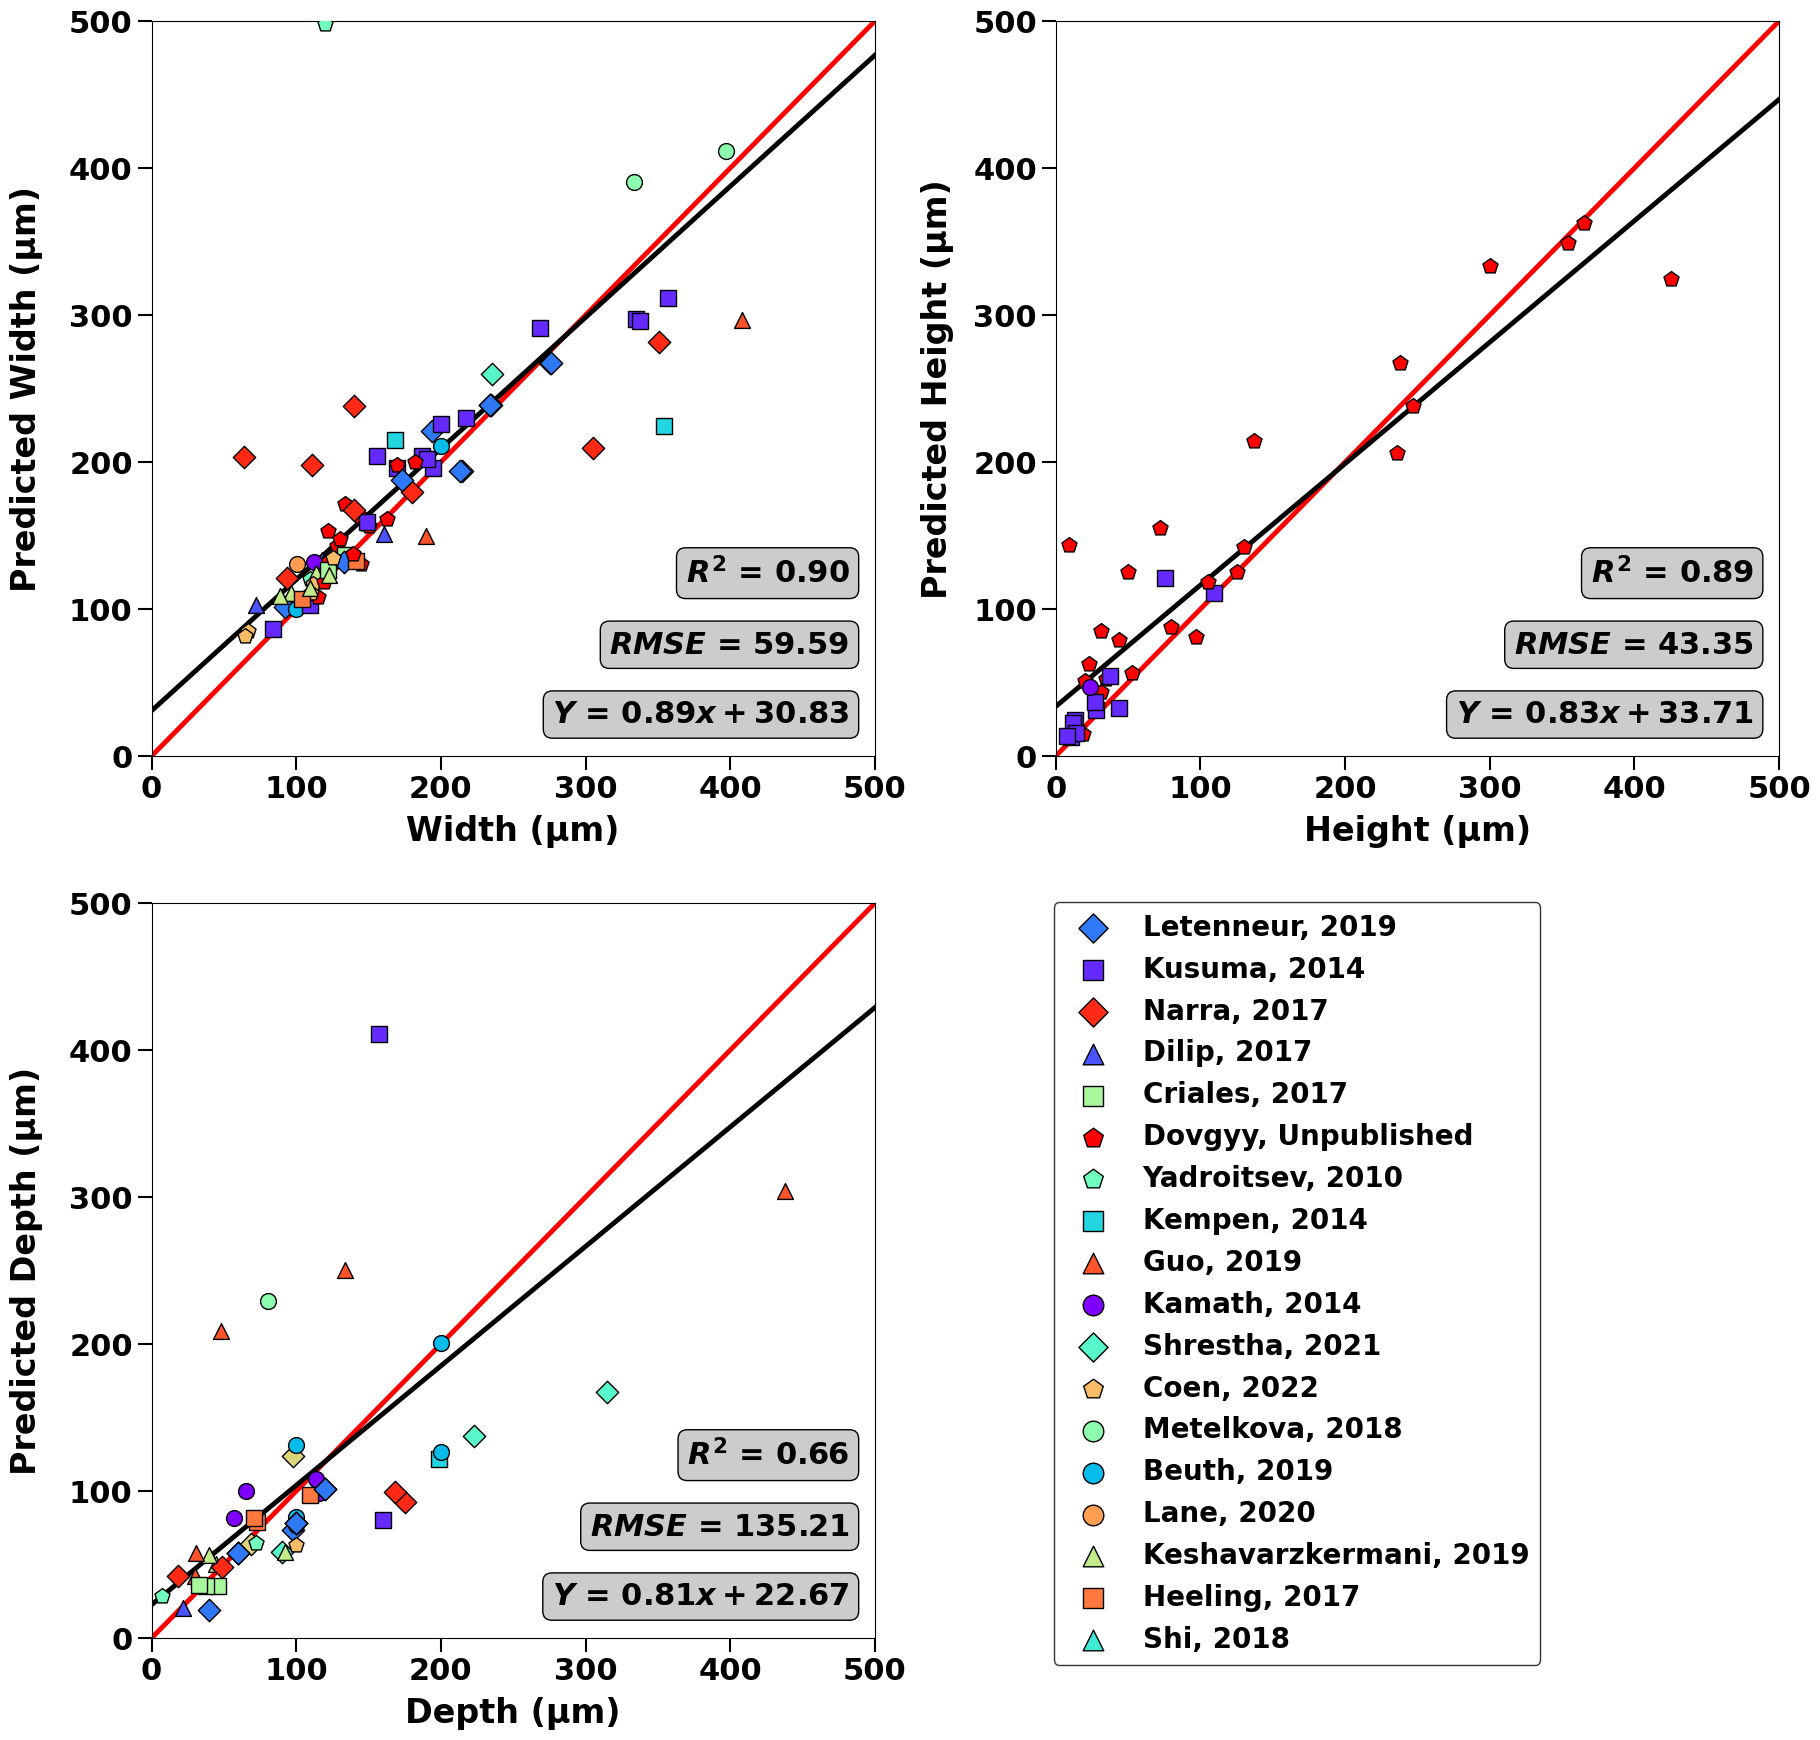

In [20]:
plot_perf()

# LightGBM

In [21]:
def objective(trial, x, y, cv, scoring):

    epsilon = 1e-15
    param = {
                "objective": "regression",
                "metric": "rmse",
                "verbosity": -1,
                "boosting_type": "gbdt",
                "n_estimators": trial.suggest_int("n_estimators", 50, 500, step=50),
                "learning_rate": trial.suggest_categorical("learning_rate", [0.0125, 0.025, 0.05, 0.1]),
                "num_leaves": trial.suggest_int("num_leaves", 2, 2048),
                "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
                "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
                "feature_fraction": min(trial.suggest_float("feature_fraction", 0.3, 1.0 + epsilon), 1.0),
                "bagging_fraction": min(trial.suggest_float("bagging_fraction", 0.3, 1.0 + epsilon), 1.0),
                "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
                "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
                "feature_pre_filter": False,
                "extra_trees": trial.suggest_categorical("extra_trees", [True, False]),
            }

    model = lgb.LGBMRegressor(**param, seed=seed)
    cv_score = cross_val_score(model, x, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    return abs(np.mean(cv_score))

In [ ]:
# Delete previous studies
optuna.delete_study(study_name="LightGBM_width", storage="sqlite:///db.sqlite3")
optuna.delete_study(study_name="LightGBM_height", storage="sqlite:///db.sqlite3")
optuna.delete_study(study_name="LightGBM_depth", storage="sqlite:///db.sqlite3")

In [70]:
%%capture capt
study_width = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="LightGBM_width")
study_height = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="LightGBM_height")
study_depth = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="LightGBM_depth")
studies = [study_width, study_height, study_depth]

# Splitter object for K-fold CV
kfold = KFold(n_splits = 5, shuffle=True, random_state=seed)
# Pass additional arguments inside another function to avoid errors
# https://www.kaggle.com/code/bextuychiev/no-bs-guide-to-hyperparameter-tuning-with-optuna
func = lambda trial: objective(trial, x, y, cv=kfold, scoring="neg_root_mean_squared_error")
for i,data in enumerate(train_scaled):
    x = data[0]
    y = data[1]

    studies[i].optimize(func, n_trials=100)

[I 2024-07-19 11:27:24,600] Using an existing study with name 'LightGBM_width' instead of creating a new one.
[I 2024-07-19 11:27:24,694] Using an existing study with name 'LightGBM_height' instead of creating a new one.
[I 2024-07-19 11:27:24,888] Using an existing study with name 'LightGBM_depth' instead of creating a new one.
[I 2024-07-19 11:27:25,229] Trial 200 finished with value: 84.72577251697646 and parameters: {'alpha': 0.017558134944811024, 'l1_ratio': 0.10235766499541865}. Best is trial 84 with value: 27.83082004591021.
[I 2024-07-19 11:27:25,295] Trial 201 finished with value: 84.83244530788116 and parameters: {'alpha': 0.042932819190552335, 'l1_ratio': 0.38578226738048893}. Best is trial 84 with value: 27.83082004591021.
[I 2024-07-19 11:27:25,349] Trial 202 finished with value: 84.70808124796315 and parameters: {'alpha': 0.00572323047936482, 'l1_ratio': 0.43510694249634807}. Best is trial 84 with value: 27.83082004591021.
[I 2024-07-19 11:27:25,402] Trial 203 finished wi

In [20]:
# http://localhost:8080/dashboard
!optuna-dashboard sqlite:///db.sqlite3b

^C


In [71]:
# Save parameters to excel
for i, study in enumerate(studies):
    trials_df = study.trials_dataframe()
    trials_df.to_excel(f"/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Melt Pool Models/LightGBM/LightGBM_{i:02d}.xlsx")

    with open(f"/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Melt Pool Models/LightGBM/LGBM_best_params_{i:02d}.json", 'w+') as f:
        json.dump(study.best_params, f)
    with open(f"/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Melt Pool Models/LightGBM/LGBM_best_value_{i:02d}.json", 'w+') as f:
        json.dump(study.best_value, f)

In [72]:
# Train with best hyperparameters
hyp_params = []
for i, study in enumerate(studies):
    path = f'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Melt Pool Models/LightGBM/LGBM_best_params_{i:02d}.json'
    with open(path, "r") as f:
        hyp_params.append(json.load(f))

In [73]:
# Compute predictions and save models
models = []
predictions = []
for i,data in enumerate(train_scaled):
    x = data[0]
    y = data[1]

    model = lgb.LGBMRegressor(**hyp_params[i])
    model.fit(x, y)
    predictions.append((model.predict(test_scaled[i][0])))
    models.append(model)

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] lambda_l2 is set=0.12408779747391502, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12408779747391502
[LightGBM] [Warning] bagging_fraction is set=0.9267259866708873, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9267259866708873
[LightGBM] [Warning] lambda_l1 is set=8.175662376548112e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.175662376548112e-08
[LightGBM] [Warning] feature_fraction is set=0.9040854097286807, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9040854097286807
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGB

/var/folders/dr/88_11bqj7nv1y6zj8hs35g3m0000gp/T/ipykernel_22693/364832982.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow', list_length)


Width (μm)
Mean squared error, RMSE = 43.57
Coefficient of determination, r2 = 0.94
Height (μm)
Mean squared error, RMSE = 41.04
Coefficient of determination, r2 = 0.90
Depth (μm)
Mean squared error, RMSE = 126.68
Coefficient of determination, r2 = 0.70


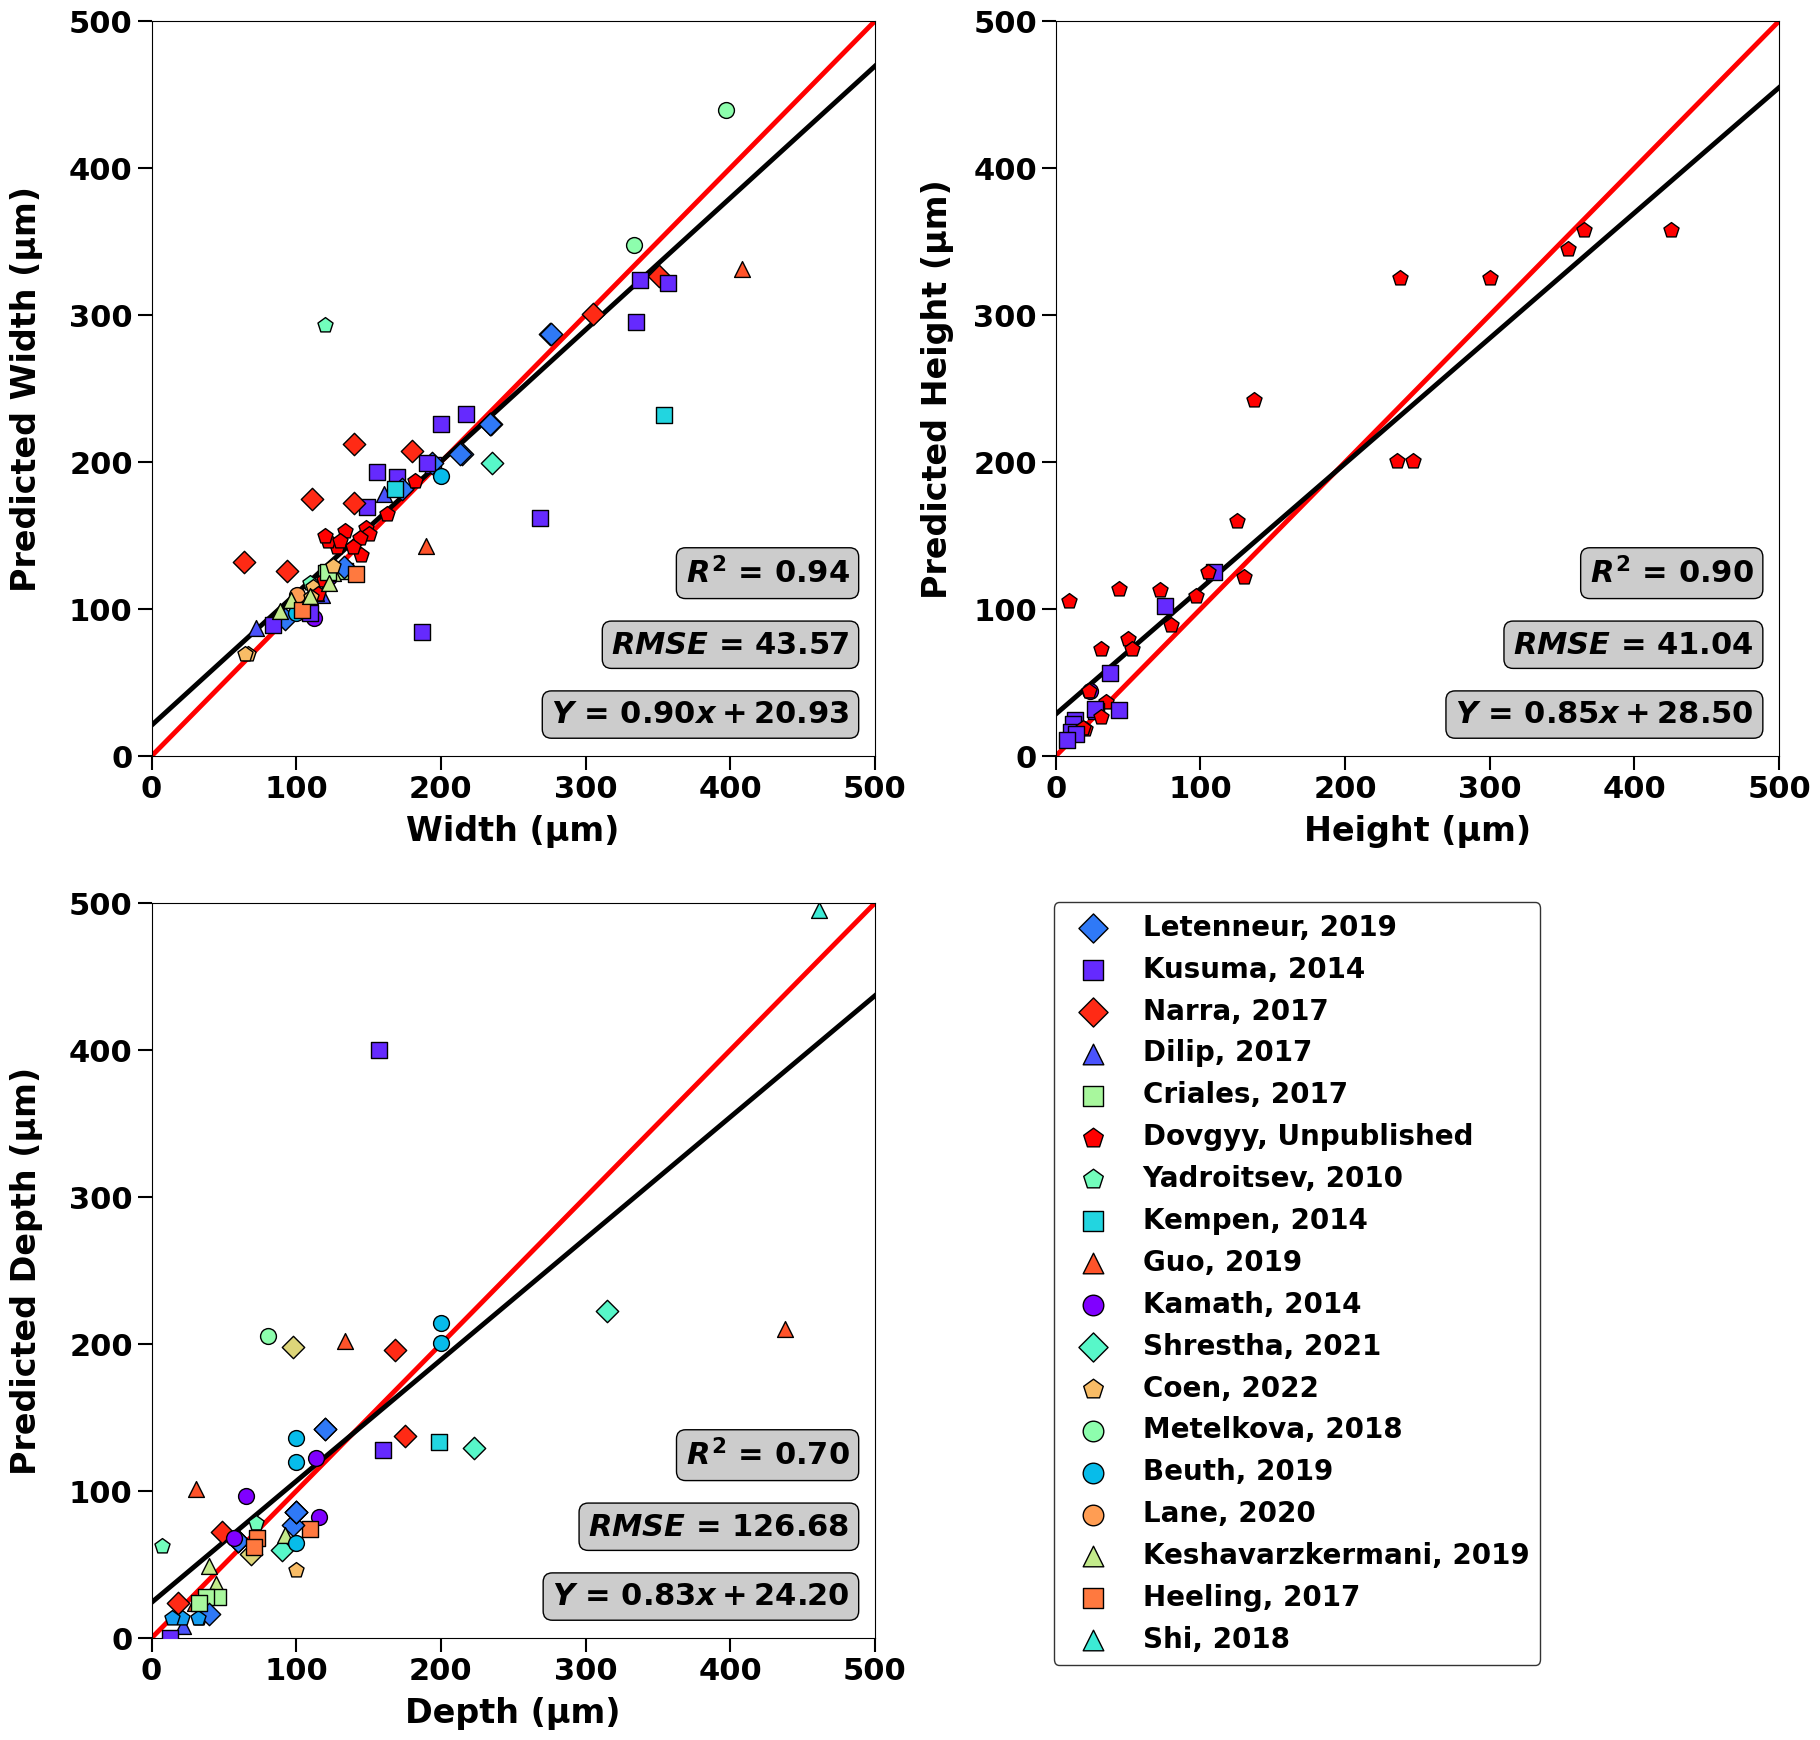

In [74]:
plot_perf()

# CatBoost

In [27]:
def objective(trial, x, y, cv, scoring):

    EPS = 1e-15
    param = {
                "loss_function": "MultiRMSE",
                "eval_metric": "MultiRMSE",
                "iterations": trial.suggest_int("iterations", 500, 2500, step=500),
                "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, step=0.05),
                "depth": trial.suggest_int("depth", 2, 9),
                "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.0001, 10.0, log=False),
                "random_strength": trial.suggest_float("random_strength", EPS, 10.0, log=False),
                "rsm": trial.suggest_float("rsm", 0.1, 1),
                "verbose": False,
                "allow_writing_files": False,
                "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
            }

    model = cb.CatBoostRegressor(**param)
    cv_score = cross_val_score(model, x, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    return abs(np.mean(cv_score))

In [28]:
def objective(trial, x, y, cv, scoring):

    EPS = 1e-15
    param = {
                "loss_function": "MultiRMSE",
                "eval_metric": "MultiRMSE",
                "iterations": trial.suggest_int("iterations", 500, 1500, step=500),
                "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, step=0.05),
                "depth": trial.suggest_int("depth", 2, 9),
                "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.0001, 5.0, log=False),
                "random_strength": trial.suggest_float("random_strength", EPS, 10.0, log=False),
                "rsm": trial.suggest_float("rsm", 0.1, 1),
                "verbose": False,
                "allow_writing_files": False,
                "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
            }

    model = cb.CatBoostRegressor(**param)
    cv_score = cross_val_score(model, x, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    return abs(np.mean(cv_score))

In [ ]:
# Delete previous studies
optuna.delete_study(study_name="CatBoost_width", storage="sqlite:///db.sqlite3")
optuna.delete_study(study_name="CatBoost_height", storage="sqlite:///db.sqlite3")
optuna.delete_study(study_name="CatBoost_depth", storage="sqlite:///db.sqlite3")

In [29]:
%%capture capt
study_width = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="CatBoost_width")
study_height = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="CatBoost_height")
study_depth = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="CatBoost_depth")
studies = [study_width, study_height, study_depth]

# Splitter object for K-fold CV
kfold = KFold(n_splits = 5, shuffle=True, random_state=seed)
# Pass additional arguments inside another function to avoid errors
# https://www.kaggle.com/code/bextuychiev/no-bs-guide-to-hyperparameter-tuning-with-optuna
func = lambda trial: objective(trial, x, y, cv=kfold, scoring="neg_root_mean_squared_error")
for i,data in enumerate(train_scaled):
    x = data[0]
    y = data[1]

    studies[i].optimize(func, n_trials=100)

[I 2024-07-18 10:29:01,689] A new study created in RDB with name: CatBoost_width
[I 2024-07-18 10:29:01,816] A new study created in RDB with name: CatBoost_height
[I 2024-07-18 10:29:01,923] A new study created in RDB with name: CatBoost_depth
[I 2024-07-18 10:29:05,878] Trial 0 finished with value: 28.369646133842537 and parameters: {'iterations': 500, 'learning_rate': 0.2, 'depth': 6, 'l2_leaf_reg': 4.654500627015612, 'random_strength': 8.601656238803837, 'rsm': 0.518199391692815, 'min_data_in_leaf': 38}. Best is trial 0 with value: 28.369646133842537.
[I 2024-07-18 10:29:06,660] Trial 1 finished with value: 36.547015641281895 and parameters: {'iterations': 1000, 'learning_rate': 0.1, 'depth': 3, 'l2_leaf_reg': 3.974006602326301, 'random_strength': 2.640751620879365, 'rsm': 0.15775954019670957, 'min_data_in_leaf': 81}. Best is trial 0 with value: 28.369646133842537.
[I 2024-07-18 10:29:07,596] Trial 2 finished with value: 28.989436076604363 and parameters: {'iterations': 1500, 'learn

In [97]:
# http://localhost:8080/dashboard
!optuna-dashboard sqlite:///db.sqlite3

^C


In [30]:
# Save parameters to excel
for i, study in enumerate(studies):
    trials_df = study.trials_dataframe()
    trials_df.to_excel(f"/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Melt Pool Models/CatBoost/CatBoost_{i:02d}.xlsx")

    with open(f'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Melt Pool Models/CatBoost/CatBoost_best_params_{i:02d}.json', 'w+') as f:
        json.dump(study.best_params, f)
    with open(f'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Melt Pool Models/CatBoost/CatBoost_best_value_{i:02d}.json', 'w+') as f:
        json.dump(study.best_value, f)

In [31]:
# Train with best hyperparameters
hyp_params = []
for i, study in enumerate(studies):
    path = f'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Melt Pool Models/CatBoost/CatBoost_best_params_{i:02d}.json'
    with open(path, "r") as f:
        hyp_params.append(json.load(f))

In [32]:
models = []
predictions = []
for i,data in enumerate(train_scaled):
    x = data[0]
    y = data[1]

    model = cb.CatBoostRegressor(**hyp_params[i])
    model.fit(x, y, verbose=False)
    predictions.append((model.predict(test_scaled[i][0])))
    models.append(model)

/var/folders/dr/88_11bqj7nv1y6zj8hs35g3m0000gp/T/ipykernel_22693/364832982.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow', list_length)


Width (μm)
Mean squared error, RMSE = 37.91
Coefficient of determination, r2 = 0.96
Height (μm)
Mean squared error, RMSE = 48.43
Coefficient of determination, r2 = 0.86
Depth (μm)
Mean squared error, RMSE = 154.49
Coefficient of determination, r2 = 0.56


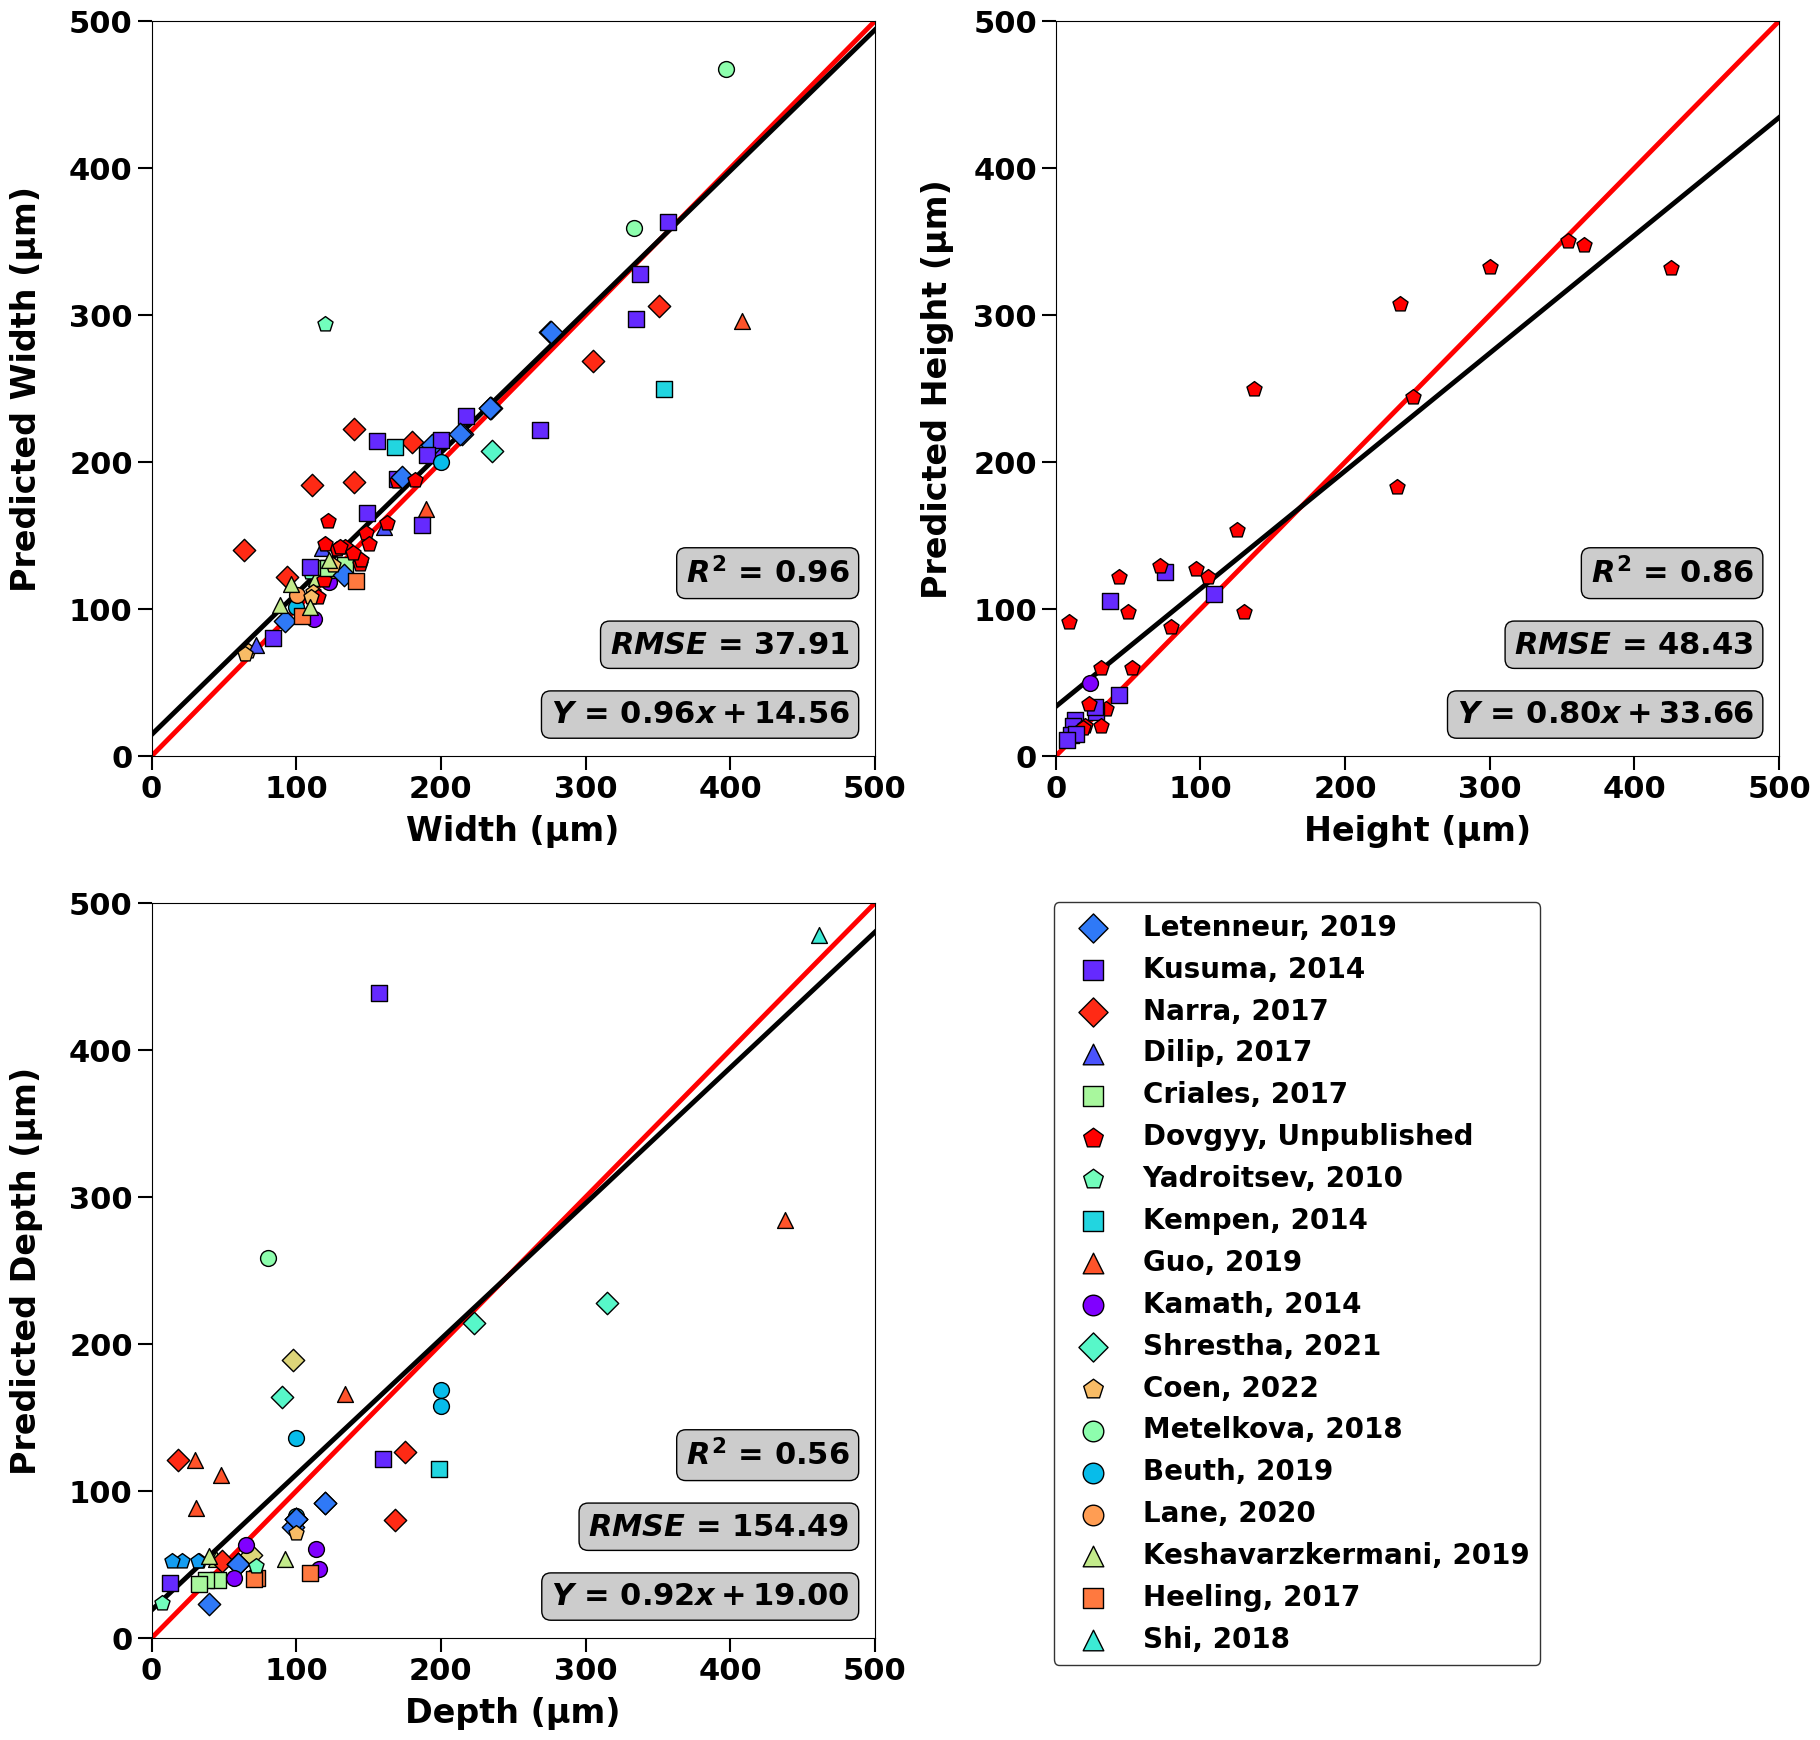

In [33]:
plot_perf()

Yield Stress (MPa)
Mean squared error, RMSE = 127.73
Coefficient of determination, r2 = 0.85


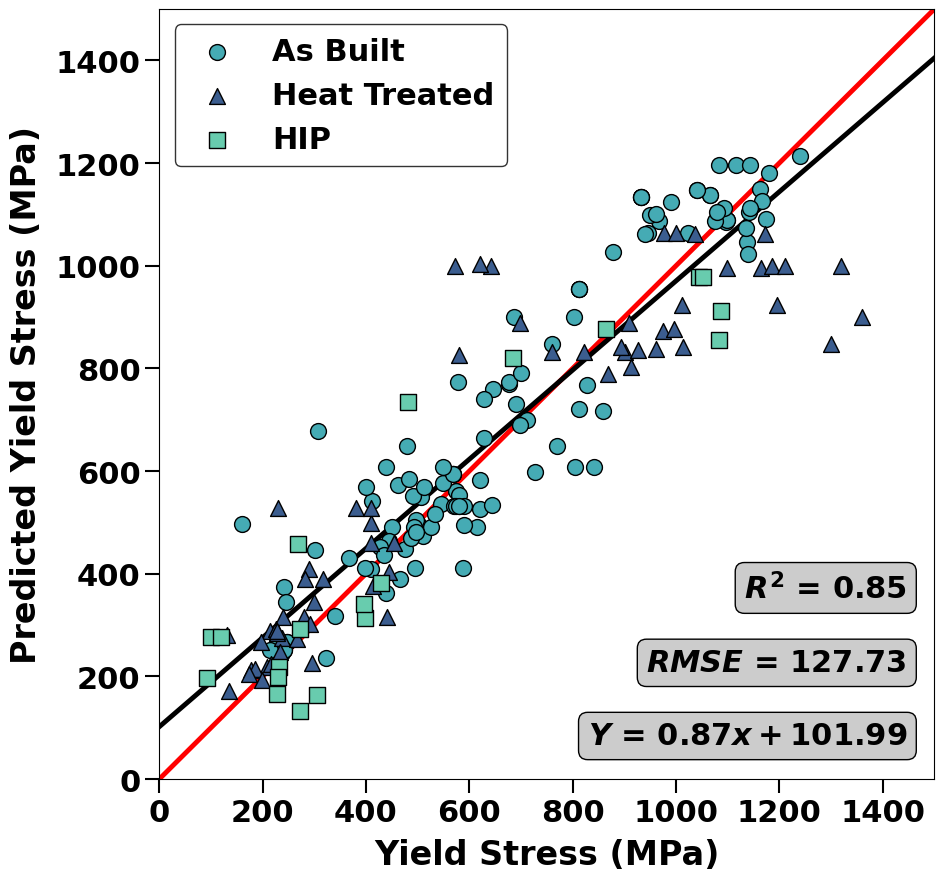

Average Work Hardening
Mean squared error, RMSE = 10.13
Coefficient of determination, r2 = 0.49


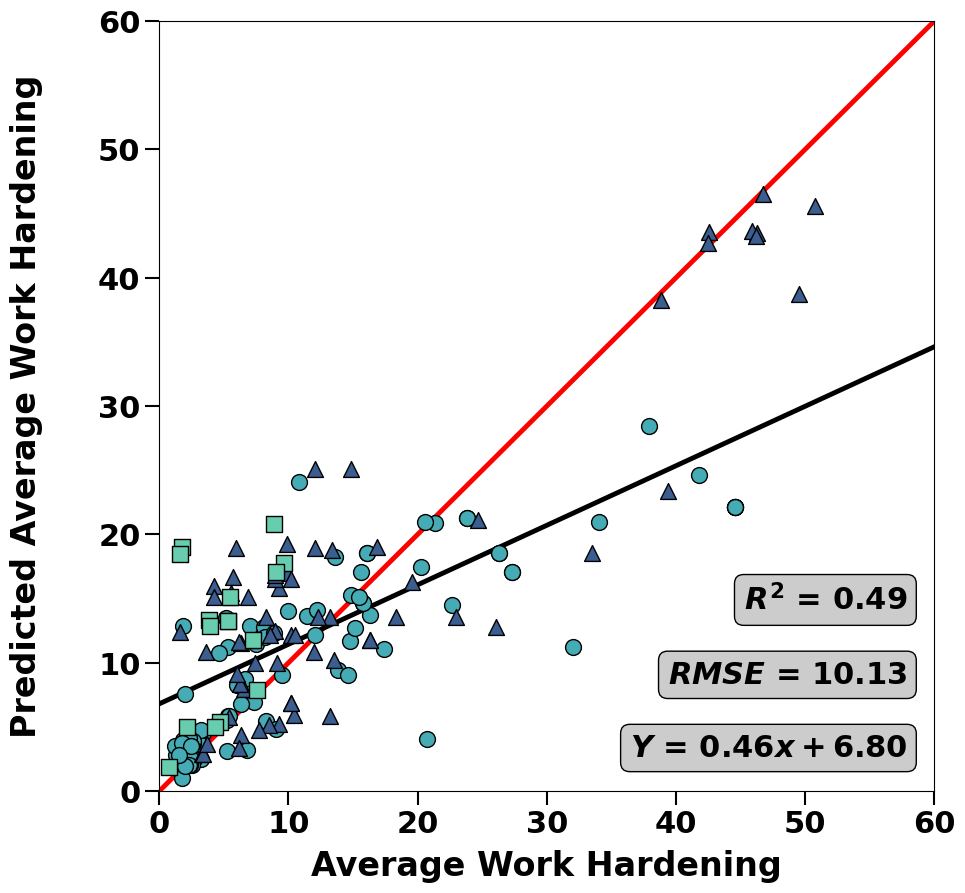

Elongation (%)
Mean squared error, RMSE = 10.58
Coefficient of determination, r2 = 0.64


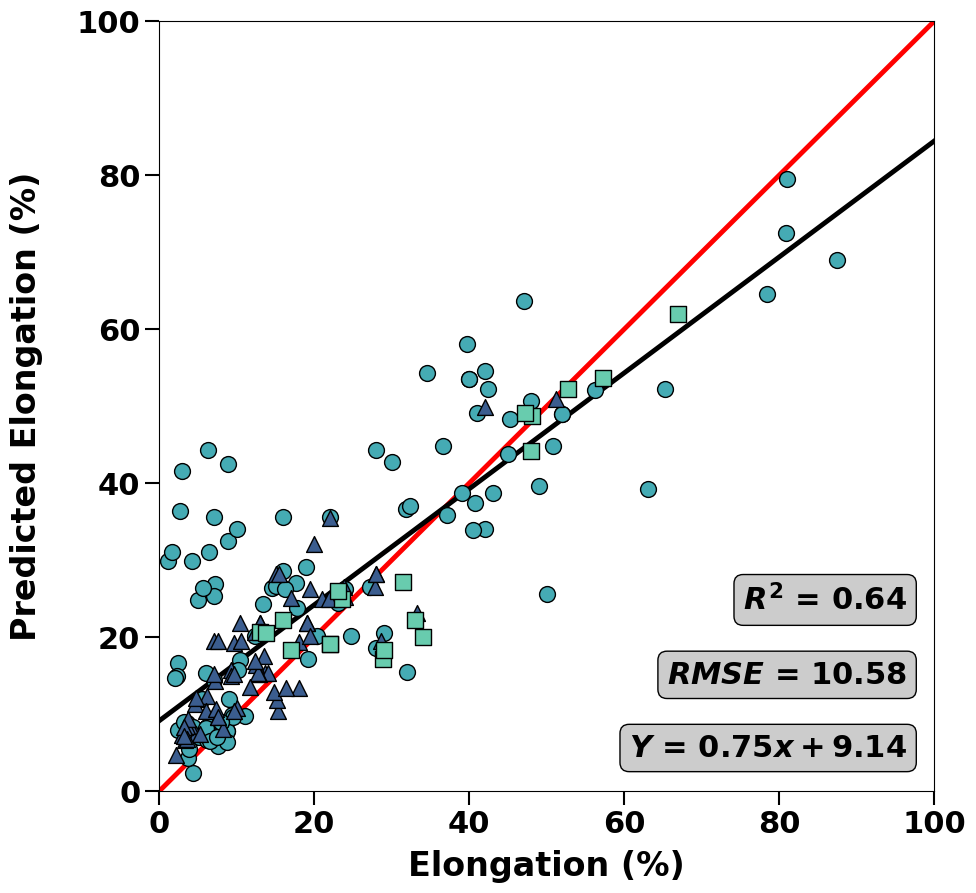

Consolidation (%)
Mean squared error, RMSE = 4.26
Coefficient of determination, r2 = 0.39


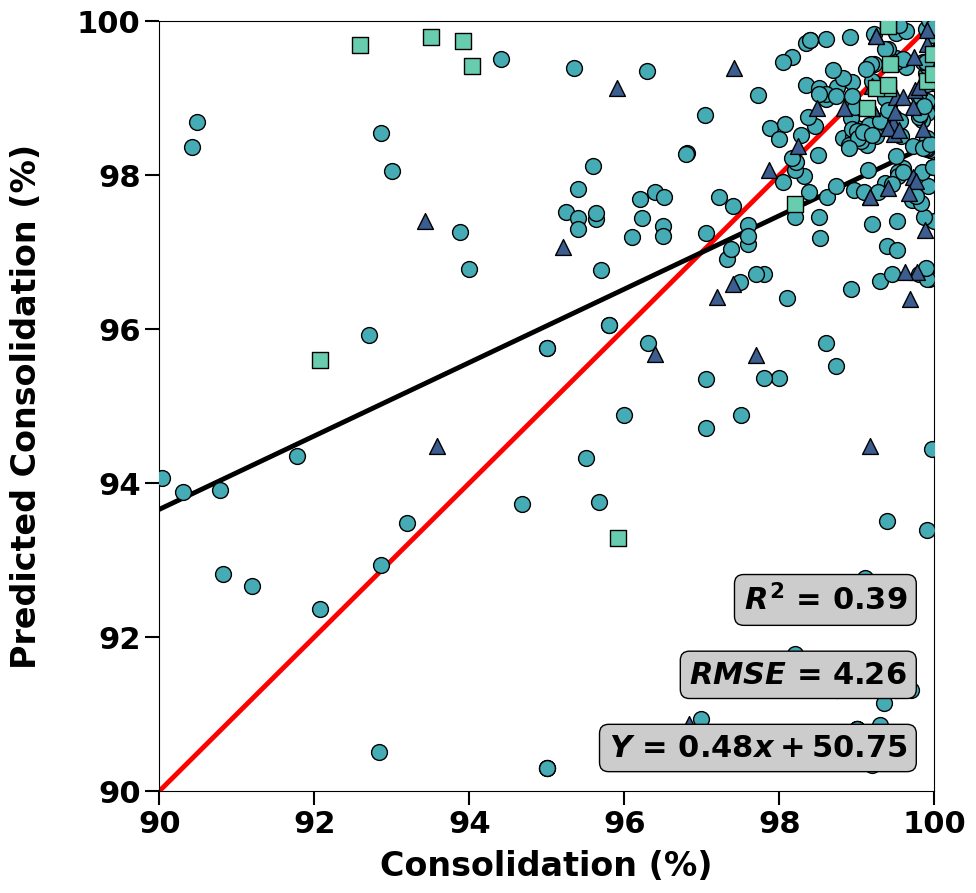

In [124]:
# Define plotting functions for visualisation

def RegLine(x):
    return slope * x + intercept

plt.rcParams.update({'font.size': 22})
pad_size = 8
txt_size = 24
m_size = 130

r2_list = []
rmse_list = []
bbox = dict(boxstyle ="round", fc ="0.8")
gr_loc = 'best'
lims = [[0,1500], [0,60], [0,100], [90,100]]

for n in range(4):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    x_index_nt = index_nt[n]
    x_index_ht = index_ht[n]
    x_index_hip = index_hip[n]
    
    ax.scatter(test_df[n][1][x_index_nt], predictions[n][x_index_nt], color='#45abb4', marker='o', s=m_size, edgecolors='k', label=(f'As Built'), zorder=5)
    ax.scatter(test_df[n][1][x_index_ht], predictions[n][x_index_ht], color='#3b5d8f', marker='^', s=m_size, edgecolors='k', label=(f'Heat Treated'), zorder=6)    
    ax.scatter(test_df[n][1][x_index_hip], predictions[n][x_index_hip], color='#68ccae', marker='s', s=m_size, edgecolors='k', label=(f'HIP'), zorder=7)   
    ax.set_xlabel(output_var[n], labelpad=pad_size, fontsize = txt_size, weight='bold')
    ax.set_ylabel((f'Predicted {output_var[n]}'), labelpad=pad_size, fontsize = txt_size, weight='bold')
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, linewidth=3.5, color='r')
    ax.set_xlim([lims[n][0], lims[n][1]])
    ax.set_ylim([lims[n][0], lims[n][1]])
    ax.tick_params(axis='both', which='major', width=1.5, length=10)

    slope, intercept, r, p, std_err = stats.linregress(test_df[n][1].values.flatten(), predictions[n][:])

    print(f'{output_var[n]}')
    # The mean squared error
    print("Mean squared error, RMSE = %.2f" % root_mean_squared_error(test_df[n][1].values.flatten(), predictions[n][:]))
    # The coefficient of determination: 1 is perfect prediction
    # Check for difference between r and r2 
    # https://www.geeksforgeeks.org/python-coefficient-of-determination-r2-score/#:~:text=Python%20%E2%80%93%20Coefficient%20of%20Determination-R2%20score.%20Coefficient%20of,is%20predictable%20from%20the%20input%20independent%20variable%20%28s%29.
    print("Coefficient of determination, r2 = %.2f" % r2_score(test_df[n][1].values.flatten(), predictions[n][:]))

    regline = list(map(RegLine, lims[n]))
    ax.plot(lims[n], regline, linewidth=3.5, color='k')
    ax.annotate(rf"$Y$ = {slope:.2f}$x + ${intercept:.2f}",
                    bbox = bbox, xy=(0.965, 0.045), xycoords='axes fraction', horizontalalignment='right', zorder=8)

    rmse_list.append(root_mean_squared_error(test_df[n][1].values.flatten(), predictions[n][:]))
    ax.annotate(rf"$RMSE$ = {abs(rmse_list[n]):.2f}",
                    bbox = bbox, xy=(0.965, 0.045+0.095), xycoords='axes fraction', horizontalalignment='right', zorder=9)

    r2_list.append(r2_score(test_df[n][1].values.flatten(), predictions[n][:]))
    ax.annotate(rf"$R^2$ = {abs(r2_list[n]):.2f}",
                    bbox = bbox, xy=(0.965, 0.045+0.095+0.095), xycoords='axes fraction', horizontalalignment='right', zorder=9)

    ax.get_yaxis().set_label_coords(-0.15,0.5)
    if n == 0:
        ax.legend(loc=gr_loc, ncol=1, edgecolor='black')
        # ax.legend(fontsize=txt_size, loc='center', bbox_to_anchor=(1.05, 1.1), edgecolor='black', ncol=4, markerscale=1.5)
        # ax.legend(fontsize=txt_size, bbox_to_anchor=(1, 1.02), edgecolor='black', markerscale=1.5,loc='upper left')

    plt.show()


In [142]:
from sklearn.metrics import mean_squared_error

# Define a function to compute RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Compute RMSE for each subset and print the results
for i, property in enumerate(output_var):
    print("Property:", property)

    x_index_nt = index_nt[i]
    x_index_ht = index_ht[i]
    x_index_hip = index_hip[i]

    rmse_as_built = root_mean_squared_error(test_df[i][1][x_index_nt], predictions[i][x_index_nt])
    rmse_heat_treated = root_mean_squared_error(test_df[i][1][x_index_ht], predictions[i][x_index_ht])
    rmse_hip = root_mean_squared_error(test_df[i][1][x_index_hip], predictions[i][x_index_hip])
    print("RMSE for As Built:", rmse_as_built)
    print("RMSE for Heat Treated:", rmse_heat_treated)
    print("RMSE for HIP:", rmse_hip)
    print()


Property: Yield Stress (MPa)
RMSE for As Built: 104.3851935030466
RMSE for Heat Treated: 162.2140282886131
RMSE for HIP: 129.60168817014662

Property: Average Work Hardening
RMSE for As Built: 12.283342349097289
RMSE for Heat Treated: 6.602294359521759
RMSE for HIP: 8.92205538302166

Property: Elongation (%)
RMSE for As Built: 13.045878853786272
RMSE for Heat Treated: 6.1494676091990765
RMSE for HIP: 6.52195855471169

Property: Consolidation (%)
RMSE for As Built: 4.602322452793042
RMSE for Heat Treated: 2.070688362910944
RMSE for HIP: 3.203337354748474



In [30]:
from sklearn.metrics import mean_squared_error
from scipy.stats import f_oneway

# Define a function to compute RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Compute RMSE for each subset and print the results
for i, property in enumerate(output_var):
    print("Property:", property)

    x_index_nt = index_nt[i]
    x_index_ht = index_ht[i]
    x_index_hip = index_hip[i]

    rmse_as_built = root_mean_squared_error(test_df[i][1][x_index_nt], predictions[i][x_index_nt])
    rmse_heat_treated = root_mean_squared_error(test_df[i][1][x_index_ht], predictions[i][x_index_ht])
    rmse_hip = root_mean_squared_error(test_df[i][1][x_index_hip], predictions[i][x_index_hip])
    print("RMSE for As Built:", rmse_as_built)
    print("RMSE for Heat Treated:", rmse_heat_treated)
    print("RMSE for HIP:", rmse_hip)
    print()

    # Perform ANOVA test
    f_statistic, p_value = f_oneway(predictions[i][x_index_nt], predictions[i][x_index_ht], predictions[i][x_index_hip])
    print("ANOVA F-statistic:", f_statistic)
    print("ANOVA p-value:", p_value)
    print()

Property: Yield Stress (MPa)
RMSE for As Built: 104.3851935030466
RMSE for Heat Treated: 162.2140282886131
RMSE for HIP: 129.60168817014662

ANOVA F-statistic: 6.352944003228118
ANOVA p-value: 0.0021176945987586497

Property: Average Work Hardening
RMSE for As Built: 12.283342349097289
RMSE for Heat Treated: 6.602294359521759
RMSE for HIP: 8.92205538302166

ANOVA F-statistic: 9.027091206861389
ANOVA p-value: 0.00018617298726349114

Property: Elongation (%)
RMSE for As Built: 13.045878853786272
RMSE for Heat Treated: 6.1494676091990765
RMSE for HIP: 6.52195855471169

ANOVA F-statistic: 10.414826588160345
ANOVA p-value: 5.0042938554868155e-05

Property: Consolidation (%)
RMSE for As Built: 4.602322452793042
RMSE for Heat Treated: 2.070688362910944
RMSE for HIP: 3.203337354748474

ANOVA F-statistic: 3.8484764681324846
ANOVA p-value: 0.022201919256425215



# Neural Network

In [106]:
def objective(trial, x, y, cv, scoring):
    params = {
        "learning_rate_init": trial.suggest_float("learning_rate_init", 0.0001, 0.1, step=0.005),
        "n_layers": trial.suggest_int("n_layers", 1, 8),
        "neurons_per_layer": [],
        "solver": "adam",
        "activation": trial.suggest_categorical("activation", ["identity", "tanh", "relu"]),
    }
    
    # Find number of neurons for each layer
    for i in range(params["n_layers"]):
        neurons = trial.suggest_int(f"neurons_layer_{i+1}", 32, 256, step=32)
        params["neurons_per_layer"].append(neurons)
    
    # Constructs hidden_layer_sizes based on the number of layers and neurons per layer
    hidden_layer_sizes = tuple(params["neurons_per_layer"])
    
    model = MLPRegressor(
        hidden_layer_sizes=hidden_layer_sizes,
        learning_rate_init=params["learning_rate_init"],
        solver=params["solver"],
        activation=params["activation"],
        max_iter=2000
    )
    
    cv_score = cross_val_score(model, x, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    return abs(np.mean(cv_score))

In [100]:
# Delete previous studies
optuna.delete_study(study_name="NN_width", storage="sqlite:///db.sqlite3")
optuna.delete_study(study_name="NN_height", storage="sqlite:///db.sqlite3")
optuna.delete_study(study_name="NN_depth", storage="sqlite:///db.sqlite3")

In [107]:
%%capture capt
study_width = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="NN_width")
study_height = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="NN_height")
study_depth = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="NN_depth")
studies = [study_width, study_height, study_depth]

# Splitter object for K-fold CV
kfold = KFold(n_splits = 5, shuffle=True, random_state=seed)
# Pass additional arguments inside another function to avoid errors
# https://www.kaggle.com/code/bextuychiev/no-bs-guide-to-hyperparameter-tuning-with-optuna
func = lambda trial: objective(trial, x, y, cv=kfold, scoring="neg_root_mean_squared_error")
for i,data in enumerate(train_scaled):
    x = data[0]
    y = data[1].squeeze()

    studies[i].optimize(func, n_trials=100)

[I 2024-07-19 11:52:05,917] Using an existing study with name 'NN_width' instead of creating a new one.
[I 2024-07-19 11:52:05,943] Using an existing study with name 'NN_height' instead of creating a new one.
[I 2024-07-19 11:52:05,962] Using an existing study with name 'NN_depth' instead of creating a new one.
[I 2024-07-19 11:52:13,587] Trial 100 finished with value: 37.79057534642224 and parameters: {'learning_rate_init': 0.0301, 'n_layers': 3, 'activation': 'relu', 'neurons_layer_1': 224, 'neurons_layer_2': 128, 'neurons_layer_3': 192}. Best is trial 100 with value: 37.79057534642224.
[I 2024-07-19 11:52:14,970] Trial 101 finished with value: 30.346113939585116 and parameters: {'learning_rate_init': 0.0301, 'n_layers': 3, 'activation': 'relu', 'neurons_layer_1': 224, 'neurons_layer_2': 128, 'neurons_layer_3': 192}. Best is trial 101 with value: 30.346113939585116.
[I 2024-07-19 11:52:17,219] Trial 102 finished with value: 32.68226169345942 and parameters: {'learning_rate_init': 0.0

In [ ]:
# http://localhost:8080/dashboard
!optuna-dashboard sqlite:///db.sqlite3b

^C


In [108]:
# Save parameters to excel
for i, study in enumerate(studies):
    trials_df = study.trials_dataframe()
    trials_df.to_excel(f"/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Melt Pool Models/Neural Network/NeuralNetwork_{i:02d}.xlsx")

    with open(f'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Melt Pool Models/Neural Network/NeuralNetwork_best_params_{i:02d}.json', 'w+') as f:
        json.dump(study.best_params, f)
    with open(f'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Melt Pool Models/Neural Network/NeuralNetwork_best_value_{i:02d}.json', 'w+') as f:
        json.dump(study.best_value, f)

In [109]:
# Train with best hyperparameters
hyp_params = []
for i, study in enumerate(studies):
    path = f'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Melt Pool Models/Neural Network/NeuralNetwork_best_params_{i:02d}.json'
    with open(path, "r") as f:
        hyp_params.append(json.load(f))

In [110]:
models = []
predictions = []
for i, data in enumerate(train_scaled):
    x = data[0]
    y = data[1]

    params = hyp_params[i]
    hidden_layer_sizes = tuple(params[f"neurons_layer_{j+1}"] for j in range(params["n_layers"]))

    model = MLPRegressor(
        hidden_layer_sizes=hidden_layer_sizes,
        learning_rate_init=params["learning_rate_init"],
        solver="adam",
        activation=params["activation"],
        random_state=seed,
        max_iter=2000
    )
    
    model.fit(x, y)
    predictions.append(model.predict(test_scaled[i][0]))
    models.append(model)

/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1624: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1624: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1624: DataConversionWarning: 

/var/folders/dr/88_11bqj7nv1y6zj8hs35g3m0000gp/T/ipykernel_22693/364832982.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow', list_length)


Width (μm)
Mean squared error, RMSE = 32.42
Coefficient of determination, r2 = 0.97
Height (μm)
Mean squared error, RMSE = 39.87
Coefficient of determination, r2 = 0.91
Depth (μm)
Mean squared error, RMSE = 116.83
Coefficient of determination, r2 = 0.75


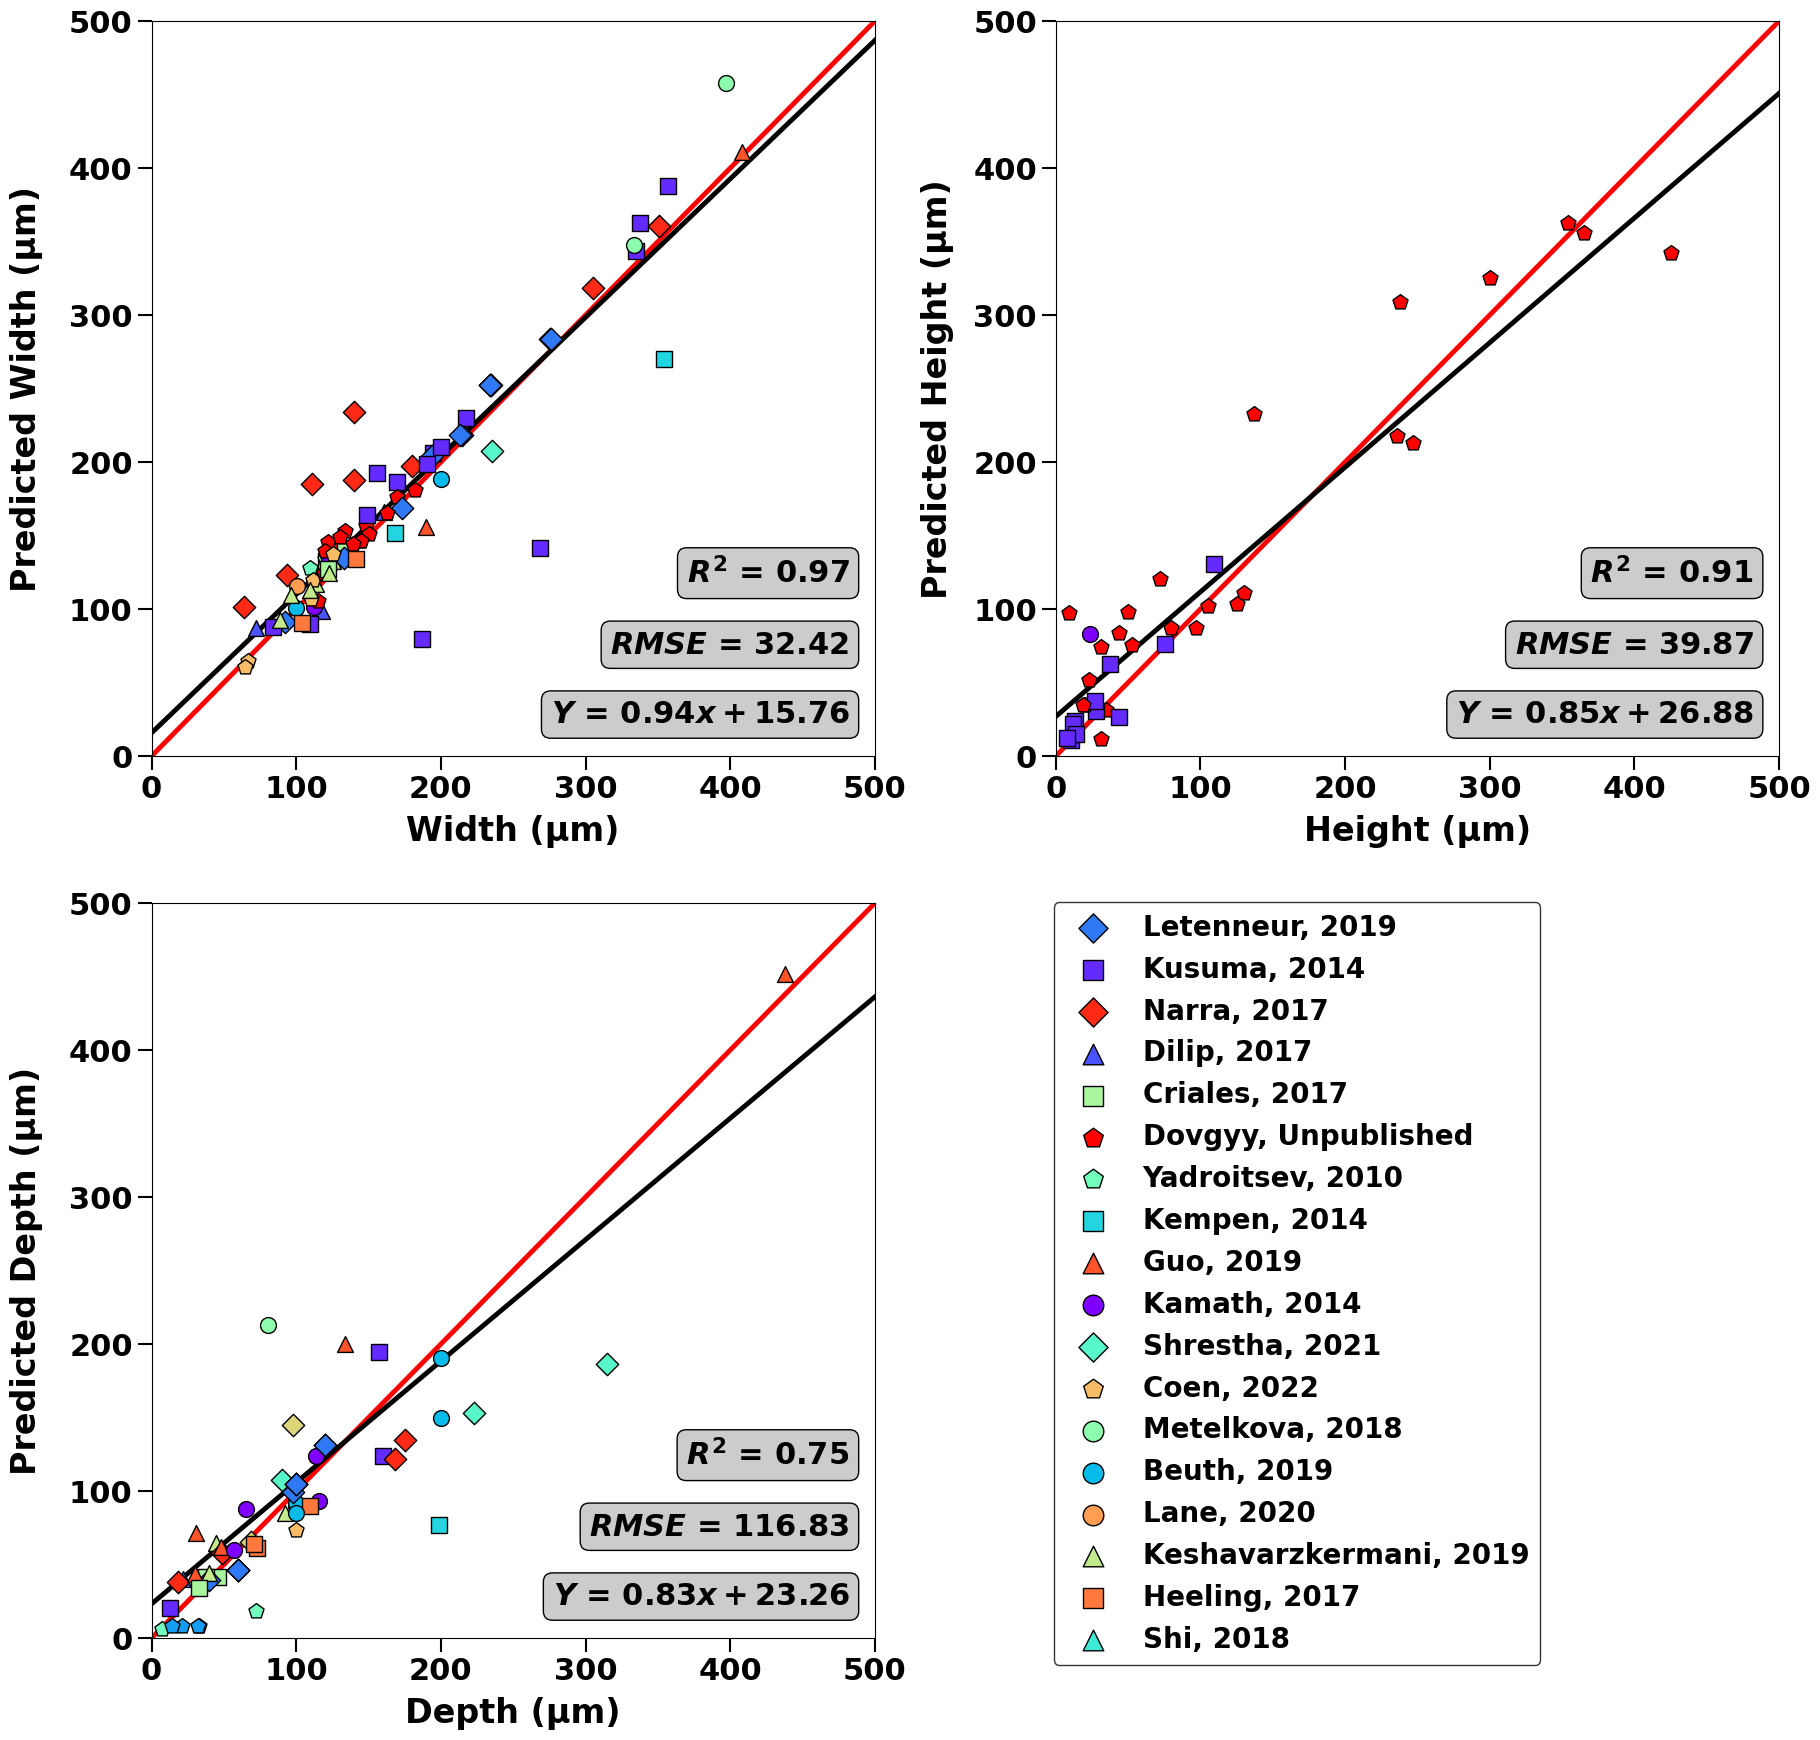

In [111]:
plot_perf()

In [47]:
# No feature importance for NN. for possible solution, ref link
# https://stackoverflow.com/questions/44460937/most-important-features-in-mlpclassifier-in-sklearn

# Support Vector Machine

In [40]:
def objective(trial, x, y, cv, scoring):
    np.random.seed(42)
    param = {
            "kernel": trial.suggest_categorical("kernel", ["rbf", "sigmoid"]),
            "degree": trial.suggest_int("degree", 1, 8, step=1),
            "gamma": trial.suggest_categorical("gamma", ["scale", "auto"]),
            "C": trial.suggest_loguniform("C", 1e-4, 1e4), # https://stats.stackexchange.com/questions/31066/what-is-the-influence-of-c-in-svms-with-linear-kernel
            "epsilon": trial.suggest_loguniform("epsilon", 1e-4, 1e4),
            "cache_size": 20000
            }

    model = SVR(**param)
    cv_score = cross_val_score(model, x, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    return abs(np.mean(cv_score))

In [50]:
# Delete previous studies
optuna.delete_study(study_name="SVM_width", storage="sqlite:///db.sqlite3")
optuna.delete_study(study_name="SVM_height", storage="sqlite:///db.sqlite3")
optuna.delete_study(study_name="SVM_depth", storage="sqlite:///db.sqlite3")

In [41]:
%%capture capt
study_width = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="SVM_width")
study_height = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="SVM_height")
study_depth = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="SVM_depth")
studies = [study_width, study_height, study_depth]

# Splitter object for K-fold CV
kfold = KFold(n_splits = 5, shuffle=True, random_state=seed)
# Pass additional arguments inside another function to avoid errors
# https://www.kaggle.com/code/bextuychiev/no-bs-guide-to-hyperparameter-tuning-with-optuna
func = lambda trial: objective(trial, x, np.ravel(y), cv=kfold, scoring="neg_root_mean_squared_error")
for i,data in enumerate(train_scaled):
    x = data[0]
    y = data[1]
    
    studies[i].optimize(func, n_trials=100)

[I 2024-07-18 12:36:25,747] A new study created in RDB with name: SVM_width
[I 2024-07-18 12:36:25,769] A new study created in RDB with name: SVM_height
[I 2024-07-18 12:36:25,796] A new study created in RDB with name: SVM_depth
[I 2024-07-18 12:36:35,364] Trial 0 finished with value: 360.5975451749544 and parameters: {'kernel': 'sigmoid', 'degree': 6, 'gamma': 'auto', 'C': 0.04436923540819278, 'epsilon': 3797.001699399754}. Best is trial 0 with value: 360.5975451749544.
[I 2024-07-18 12:36:36,105] Trial 1 finished with value: 72.74537973004601 and parameters: {'kernel': 'rbf', 'degree': 8, 'gamma': 'auto', 'C': 65.8877400305328, 'epsilon': 0.00029220162373346534}. Best is trial 1 with value: 72.74537973004601.
[I 2024-07-18 12:36:36,168] Trial 2 finished with value: 37.327532740941706 and parameters: {'kernel': 'rbf', 'degree': 6, 'gamma': 'auto', 'C': 3797.0372589276035, 'epsilon': 2.724390957899278}. Best is trial 2 with value: 37.327532740941706.
[I 2024-07-18 12:36:36,222] Trial 3

In [ ]:
# http://localhost:8080/dashboard
!optuna-dashboard sqlite:///db.sqlite3b

^C


In [42]:
# Save parameters to excel
for i, study in enumerate(studies):
    trials_df = study.trials_dataframe()
    trials_df.to_excel(f"/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Melt Pool Models/SVM/SVM_{i:02d}.xlsx")

    with open(f'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Melt Pool Models/SVM/SVM_best_params_{i:02d}.json', 'w+') as f:
        json.dump(study.best_params, f)
    with open(f'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Melt Pool Models/SVM/SVM_best_value_{i:02d}.json', 'w+') as f:
        json.dump(study.best_value, f)

In [43]:
# Train with best hyperparameters
hyp_params = []
for i, study in enumerate(studies):
    path = f'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Melt Pool Models/SVM/SVM_best_params_{i:02d}.json'
    with open(path, "r") as f:
        hyp_params.append(json.load(f))

In [44]:
models = []
predictions = []
for i,data in enumerate(train_scaled):
    x = data[0]
    y = data[1]

    model = SVR(**hyp_params[i])
    model.fit(x, y)
    predictions.append((model.predict(test_scaled[i][0])))
    models.append(model)

/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


/var/folders/dr/88_11bqj7nv1y6zj8hs35g3m0000gp/T/ipykernel_22693/364832982.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow', list_length)


Width (μm)
Mean squared error, RMSE = 42.17
Coefficient of determination, r2 = 0.95
Height (μm)
Mean squared error, RMSE = 38.08
Coefficient of determination, r2 = 0.92
Depth (μm)
Mean squared error, RMSE = 118.80
Coefficient of determination, r2 = 0.74


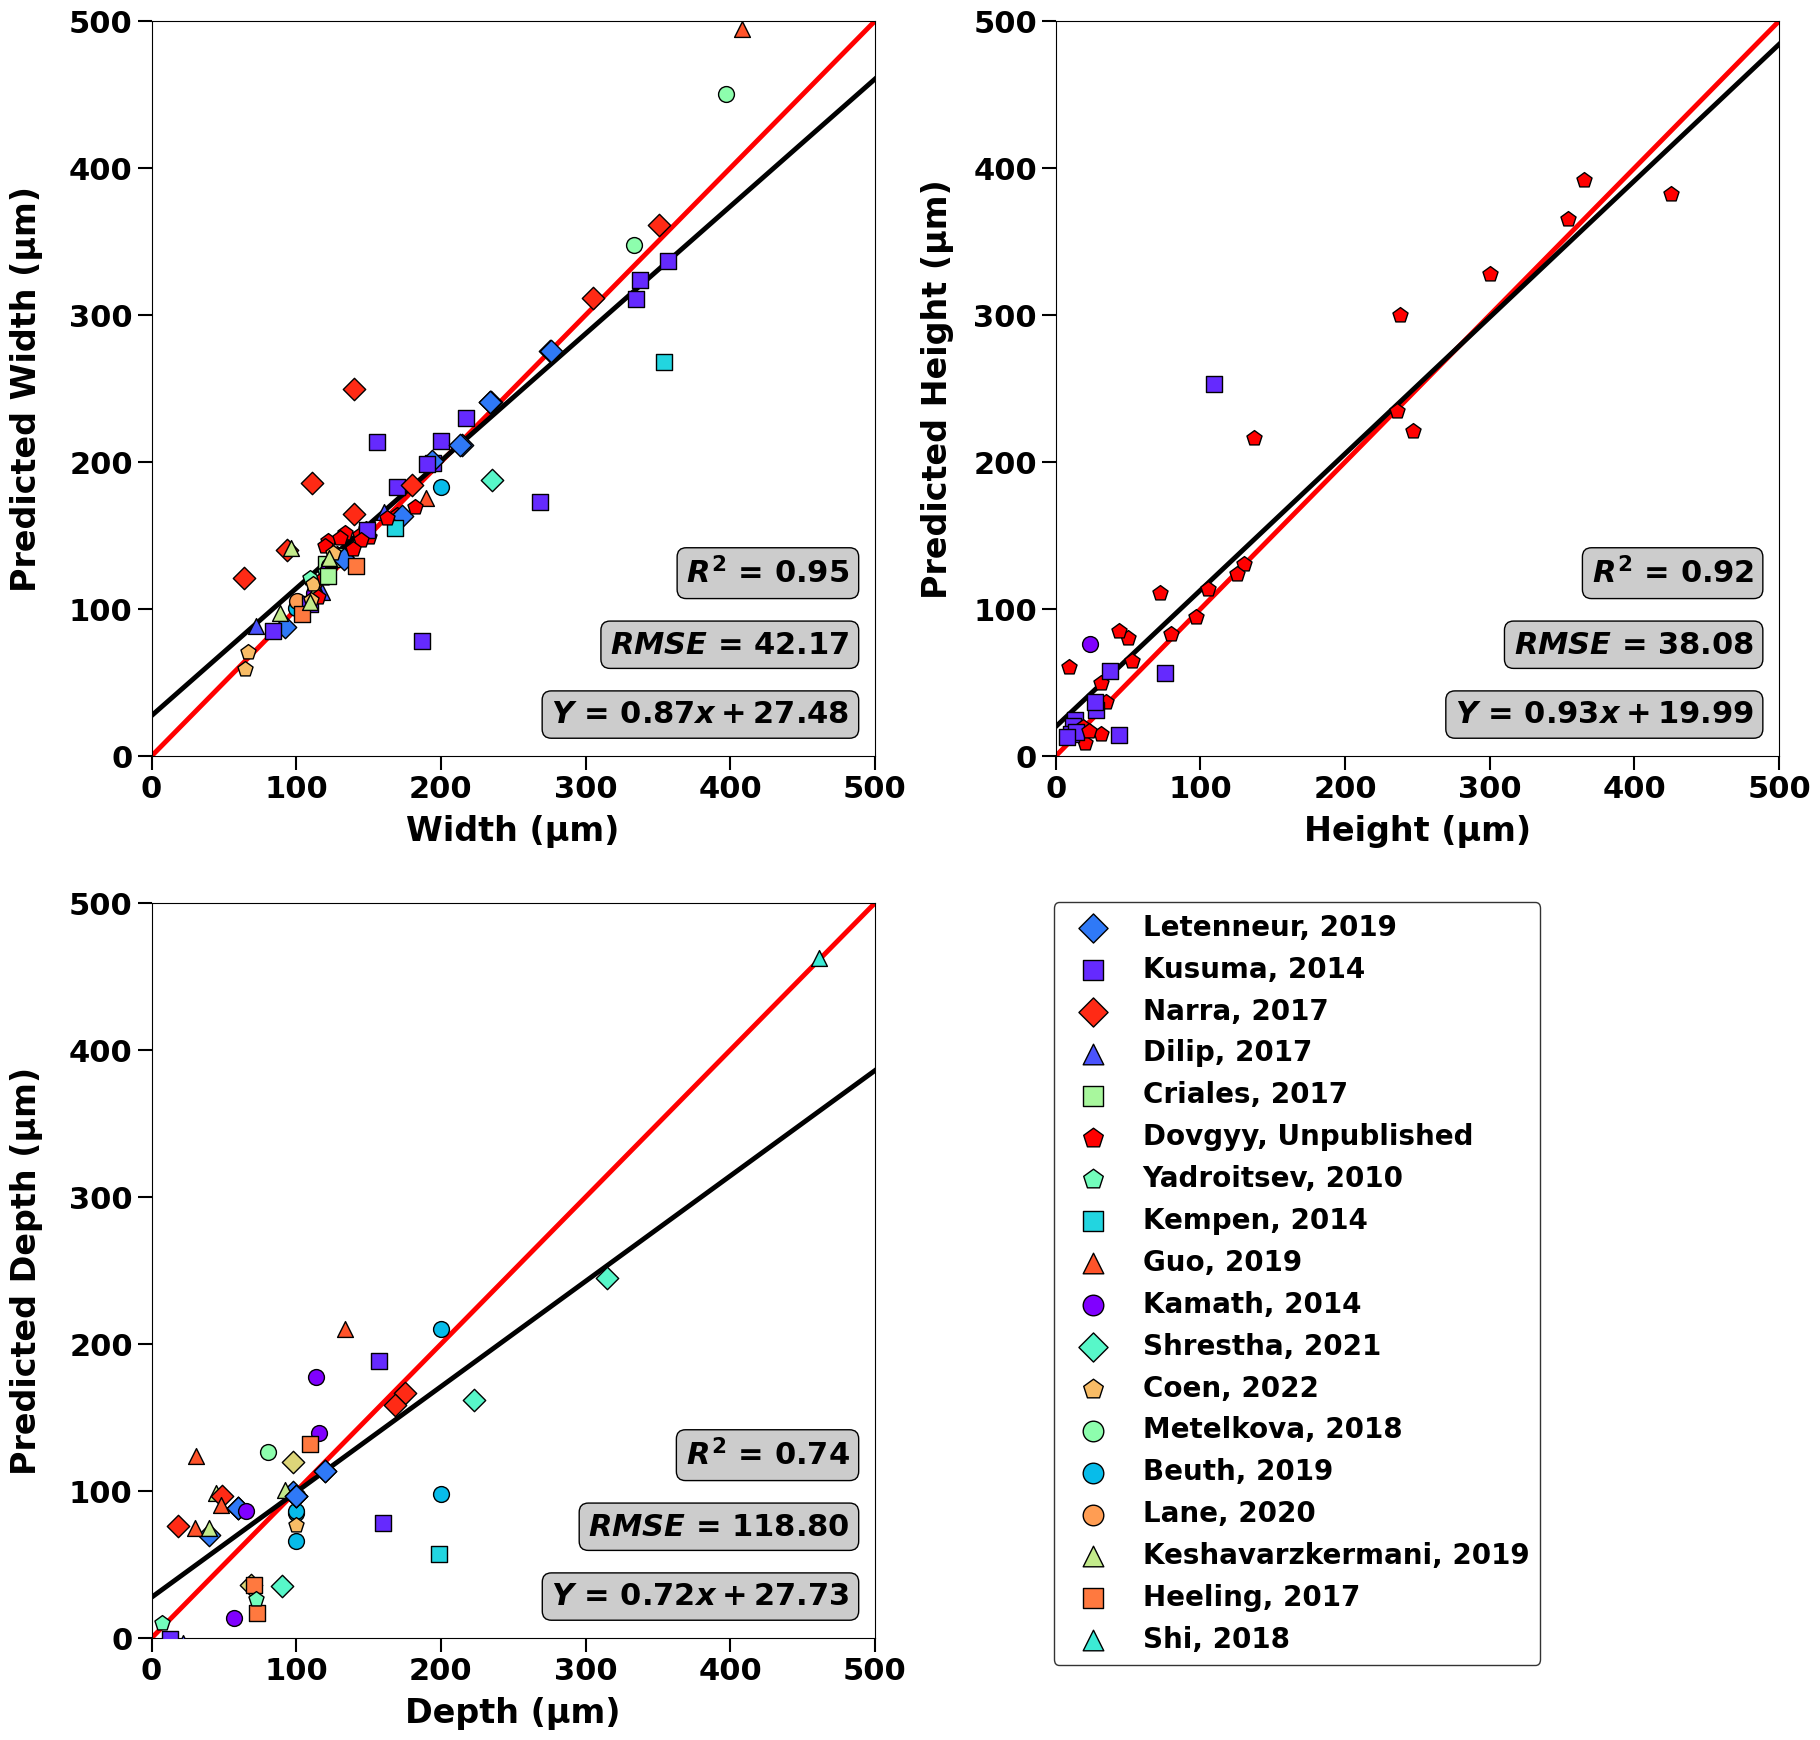

In [45]:
plot_perf()

In [56]:
# No feature importance for SVM. for possible solution, ref link
# https://stackoverflow.com/questions/48380962/what-is-the-python-code-to-show-the-feature-importance-in-svm

# Decision Tree

In [46]:
def objective(trial, x, y, cv, scoring):

    param = {
            # No Poisson criterion as it can't take negative inputs (in the case of negative hardening rates)
            "criterion": trial.suggest_categorical("criterion", ["squared_error", "friedman_mse", "absolute_error"]),
            "max_depth": trial.suggest_int("max_depth", 2, 20, step=1),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 20, step=2),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10, step=1)
        }

    model = DecisionTreeRegressor(**param)
    cv_score = cross_val_score(model, x, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    return abs(np.mean(cv_score))

In [59]:
# Delete previous studies
optuna.delete_study(study_name="DecisionTree_width", storage="sqlite:///db.sqlite3")
optuna.delete_study(study_name="DecisionTree_height", storage="sqlite:///db.sqlite3")
optuna.delete_study(study_name="DecisionTree_depth", storage="sqlite:///db.sqlite3")

In [47]:
%%capture capt
study_width = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="DecisionTree_width")
study_height = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="DecisionTree_height")
study_depth = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="DecisionTree_depth")
studies = [study_width, study_height, study_depth]

# Splitter object for K-fold CV
kfold = KFold(n_splits = 5, shuffle=True, random_state=seed)
# Pass additional arguments inside another function to avoid errors
# https://www.kaggle.com/code/bextuychiev/no-bs-guide-to-hyperparameter-tuning-with-optuna
func = lambda trial: objective(trial, x, y, cv=kfold, scoring="neg_root_mean_squared_error")
for i,data in enumerate(train_scaled):
    x = data[0]
    y = data[1]

    studies[i].optimize(func, n_trials=100)

[I 2024-07-18 12:36:59,065] A new study created in RDB with name: DecisionTree_width
[I 2024-07-18 12:36:59,092] A new study created in RDB with name: DecisionTree_height
[I 2024-07-18 12:36:59,116] A new study created in RDB with name: DecisionTree_depth
[I 2024-07-18 12:36:59,517] Trial 0 finished with value: 69.50581309148413 and parameters: {'criterion': 'squared_error', 'max_depth': 18, 'min_samples_split': 16, 'min_samples_leaf': 9}. Best is trial 0 with value: 69.50581309148413.
[I 2024-07-18 12:36:59,598] Trial 1 finished with value: 69.50581309148414 and parameters: {'criterion': 'squared_error', 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 9}. Best is trial 0 with value: 69.50581309148413.
[I 2024-07-18 12:36:59,636] Trial 2 finished with value: 78.03964949830112 and parameters: {'criterion': 'absolute_error', 'max_depth': 3, 'min_samples_split': 18, 'min_samples_leaf': 5}. Best is trial 0 with value: 69.50581309148413.
[I 2024-07-18 12:36:59,674] Trial 3 fini

In [48]:
# http://localhost:8080/dashboard
# !optuna-dashboard sqlite:///db.sqlite3b

In [49]:
# Save parameters to excel
for i, study in enumerate(studies):
    trials_df = study.trials_dataframe()
    trials_df.to_excel(f"/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Melt Pool Models/Decision Tree/DTree_{i:02d}.xlsx")

    with open(f'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Melt Pool Models/Decision Tree/DTree_best_params_{i:02d}.json', 'w+') as f:
        json.dump(study.best_params, f)
    with open(f'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Melt Pool Models/Decision Tree/DTree_best_value_{i:02d}.json', 'w+') as f:
        json.dump(study.best_value, f)

In [50]:
# Train with best hyperparameters
hyp_params = []
for i, study in enumerate(studies):
    path = f'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Melt Pool Models/Decision Tree/DTree_best_params_{i:02d}.json'
    with open(path, "r") as f:
        hyp_params.append(json.load(f))

In [51]:
models = []
predictions = []
for i,data in enumerate(train_scaled):
    x = data[0]
    y = data[1]

    model = DecisionTreeRegressor(**hyp_params[i])
    model.fit(x, y)
    predictions.append((model.predict(test_scaled[i][0])))
    models.append(model)

/var/folders/dr/88_11bqj7nv1y6zj8hs35g3m0000gp/T/ipykernel_22693/364832982.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow', list_length)


Width (μm)
Mean squared error, RMSE = 52.24
Coefficient of determination, r2 = 0.92
Height (μm)
Mean squared error, RMSE = 44.53
Coefficient of determination, r2 = 0.89
Depth (μm)
Mean squared error, RMSE = 128.81
Coefficient of determination, r2 = 0.69


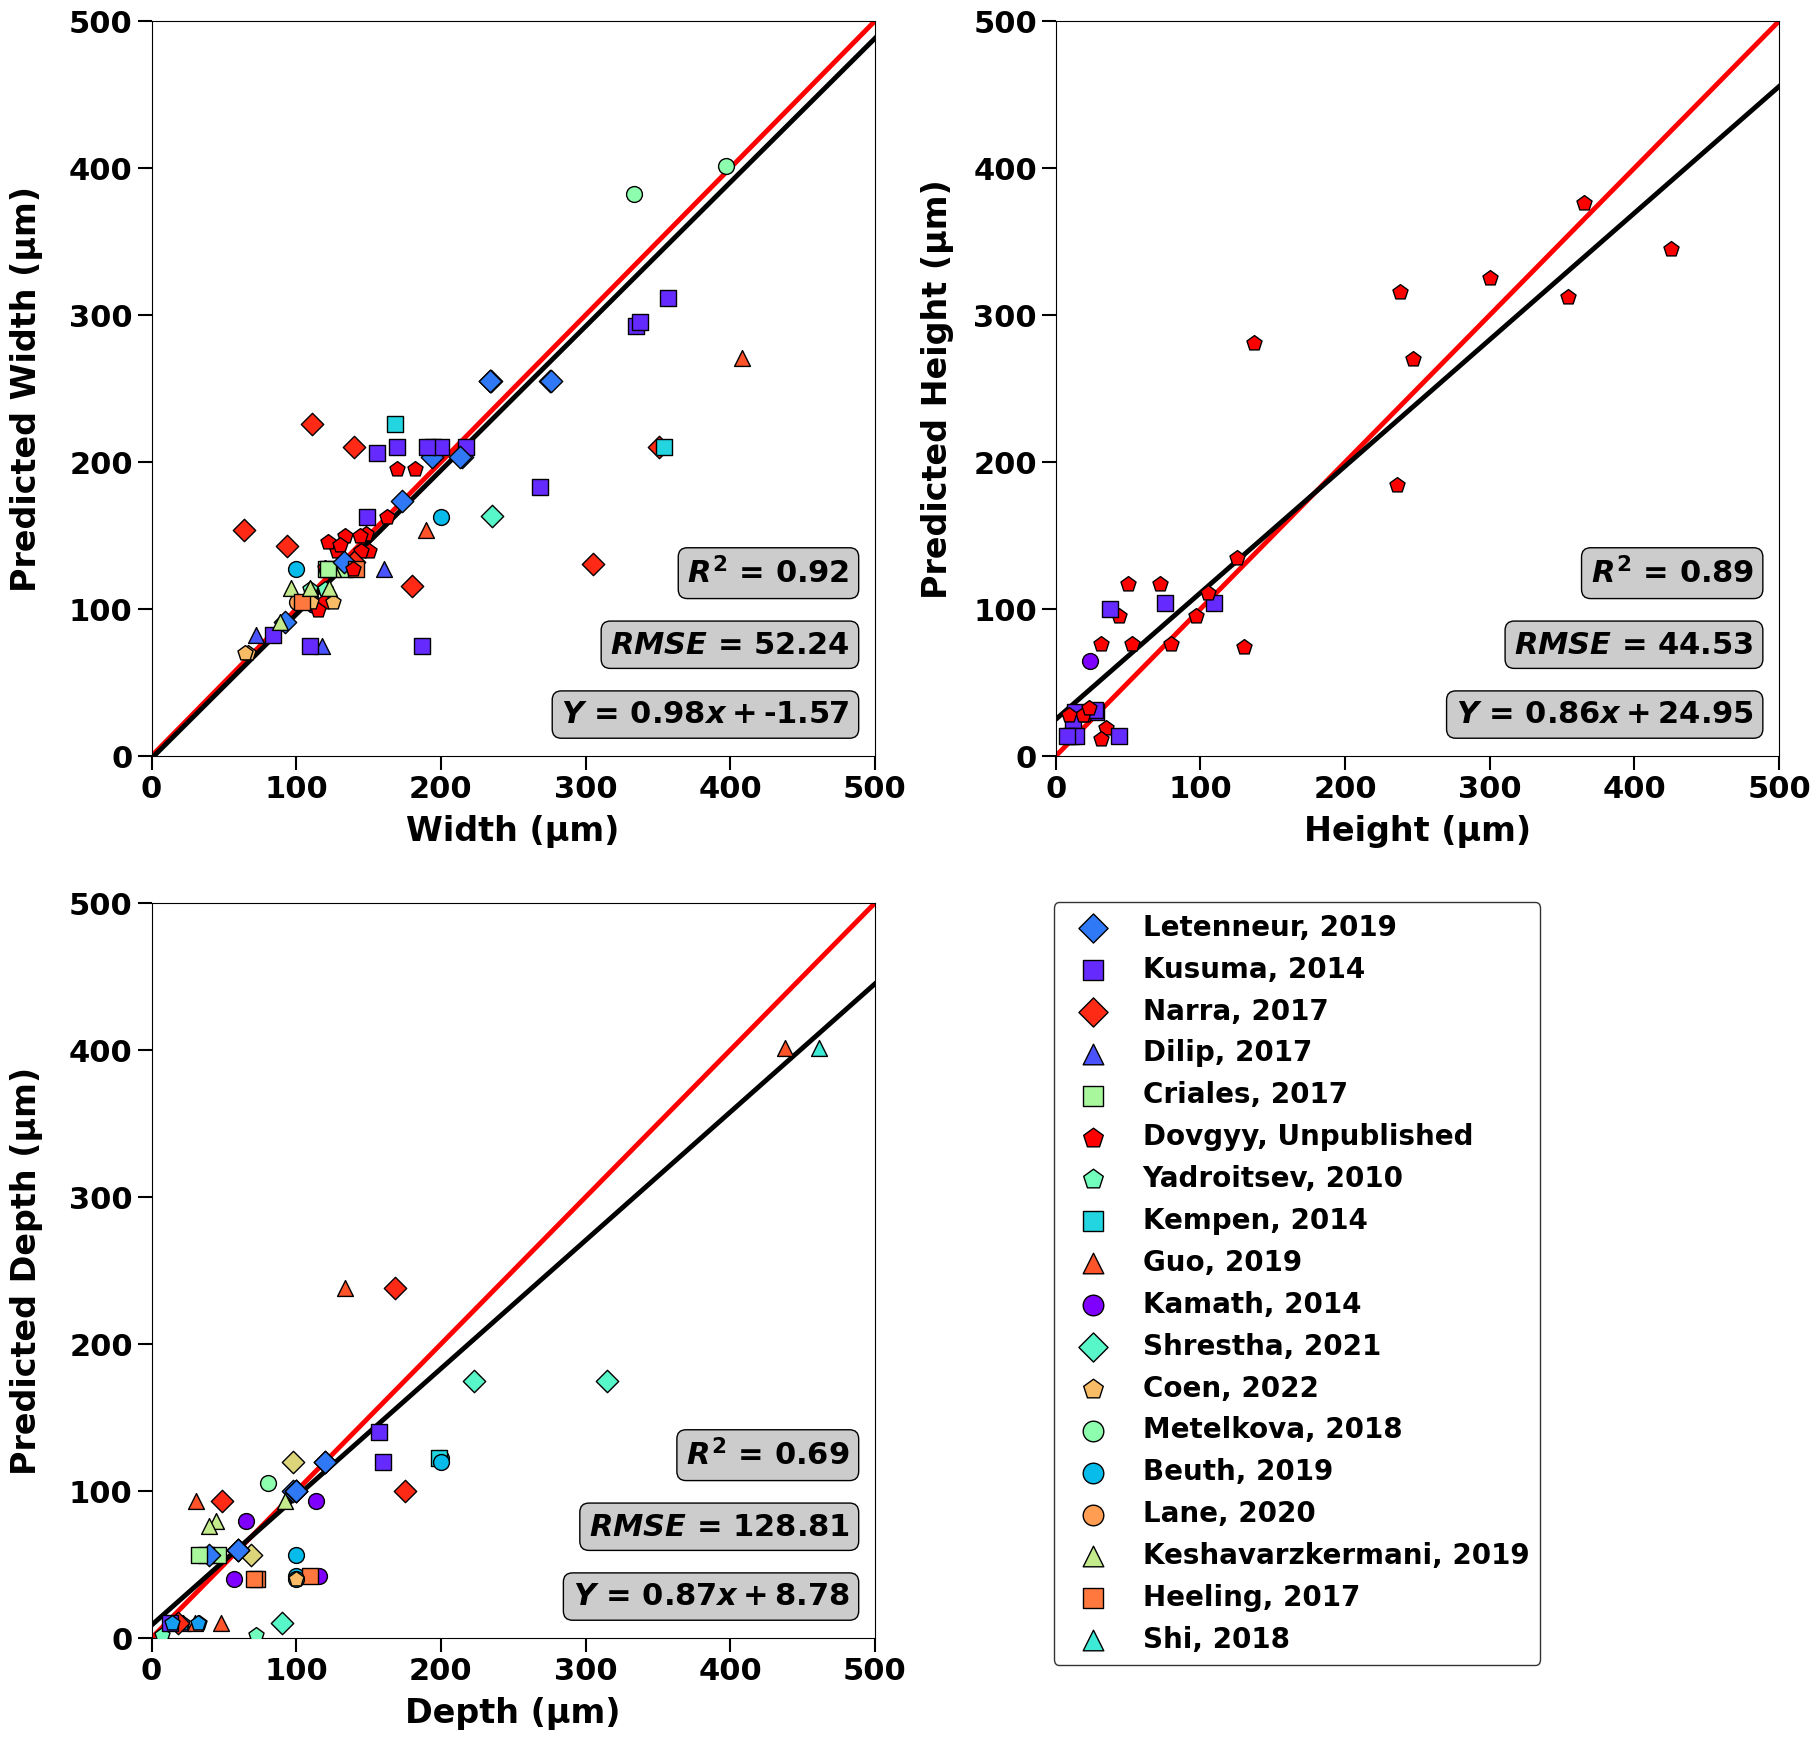

In [52]:
plot_perf()

# Random Forest

In [53]:
def objective(trial, x, y, cv, scoring):

    param = {
            # No Poisson criterion as it can't take negative inputs (in the case of negative hardening rates)
            "criterion": trial.suggest_categorical("criterion", ["squared_error", "friedman_mse", "absolute_error"]),
            "n_estimators": trial.suggest_int('n_estimators', 50, 300, step=10),
            "max_depth": trial.suggest_int("max_depth", 2, 10, step=2),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 20, step=2),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10, step=1)
        }

    model = RandomForestRegressor(**param)
    cv_score = cross_val_score(model, x, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    return abs(np.mean(cv_score))

In [67]:
# Delete previous studies
optuna.delete_study(study_name="RandomForest_width", storage="sqlite:///db.sqlite3")
optuna.delete_study(study_name="RandomForest_height", storage="sqlite:///db.sqlite3")
optuna.delete_study(study_name="RandomForest_depth", storage="sqlite:///db.sqlite3")

In [54]:
%%capture capt
study_width = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="RandomForest_width")
study_height = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="RandomForest_height")
study_depth = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="RandomForest_depth")
studies = [study_width, study_height, study_depth]

# Splitter object for K-fold CV
kfold = KFold(n_splits = 5, shuffle=True, random_state=seed)
# Pass additional arguments inside another function to avoid errors
# https://www.kaggle.com/code/bextuychiev/no-bs-guide-to-hyperparameter-tuning-with-optuna
func = lambda trial: objective(trial, x, np.ravel(y), cv=kfold, scoring="neg_root_mean_squared_error")
for i,data in enumerate(train_scaled):
    x = data[0]
    y = data[1]

    studies[i].optimize(func, n_trials=100)

[I 2024-07-18 12:37:17,864] A new study created in RDB with name: RandomForest_width
[I 2024-07-18 12:37:17,887] A new study created in RDB with name: RandomForest_height
[I 2024-07-18 12:37:17,915] A new study created in RDB with name: RandomForest_depth


[I 2024-07-18 12:37:19,361] Trial 0 finished with value: 61.77296701969232 and parameters: {'criterion': 'absolute_error', 'n_estimators': 270, 'max_depth': 4, 'min_samples_split': 16, 'min_samples_leaf': 6}. Best is trial 0 with value: 61.77296701969232.
[I 2024-07-18 12:37:19,624] Trial 1 finished with value: 74.92336050432763 and parameters: {'criterion': 'squared_error', 'n_estimators': 170, 'max_depth': 2, 'min_samples_split': 14, 'min_samples_leaf': 6}. Best is trial 0 with value: 61.77296701969232.
[I 2024-07-18 12:37:20,367] Trial 2 finished with value: 61.62525478278887 and parameters: {'criterion': 'absolute_error', 'n_estimators': 280, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 2 with value: 61.62525478278887.
[I 2024-07-18 12:37:20,499] Trial 3 finished with value: 63.69343315418412 and parameters: {'criterion': 'friedman_mse', 'n_estimators': 110, 'max_depth': 10, 'min_samples_split': 20, 'min_samples_leaf': 8}. Best is trial 2 with val

In [55]:
# http://localhost:8080/dashboard
!optuna-dashboard sqlite:///db.sqlite3

^C


In [55]:
# Save parameters to excel
for i, study in enumerate(studies):
    trials_df = study.trials_dataframe()
    trials_df.to_excel(f"/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Melt Pool Models/Random Forest/RForest_{i:02d}.xlsx")

    with open(f'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Melt Pool Models/Random Forest/RForest_best_params_{i:02d}.json', 'w+') as f:
        json.dump(study.best_params, f)
    with open(f'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Melt Pool Models/Random Forest/RForest_best_value_{i:02d}.json', 'w+') as f:
        json.dump(study.best_value, f)

In [56]:
# Train with best hyperparameters
hyp_params = []
for i, study in enumerate(studies):
    path = f'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Melt Pool Models/Random Forest/RForest_best_params_{i:02d}.json'
    with open(path, "r") as f:
        hyp_params.append(json.load(f))

In [57]:
models = []
predictions = []
for i,data in enumerate(train_scaled):
    x = data[0]
    y = data[1]

    model = RandomForestRegressor(**hyp_params[i])
    model.fit(x, y)
    predictions.append((model.predict(test_scaled[i][0])))
    models.append(model)

/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


/var/folders/dr/88_11bqj7nv1y6zj8hs35g3m0000gp/T/ipykernel_22693/364832982.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow', list_length)


Width (μm)
Mean squared error, RMSE = 49.60
Coefficient of determination, r2 = 0.93
Height (μm)
Mean squared error, RMSE = 59.19
Coefficient of determination, r2 = 0.80
Depth (μm)
Mean squared error, RMSE = 117.40
Coefficient of determination, r2 = 0.74


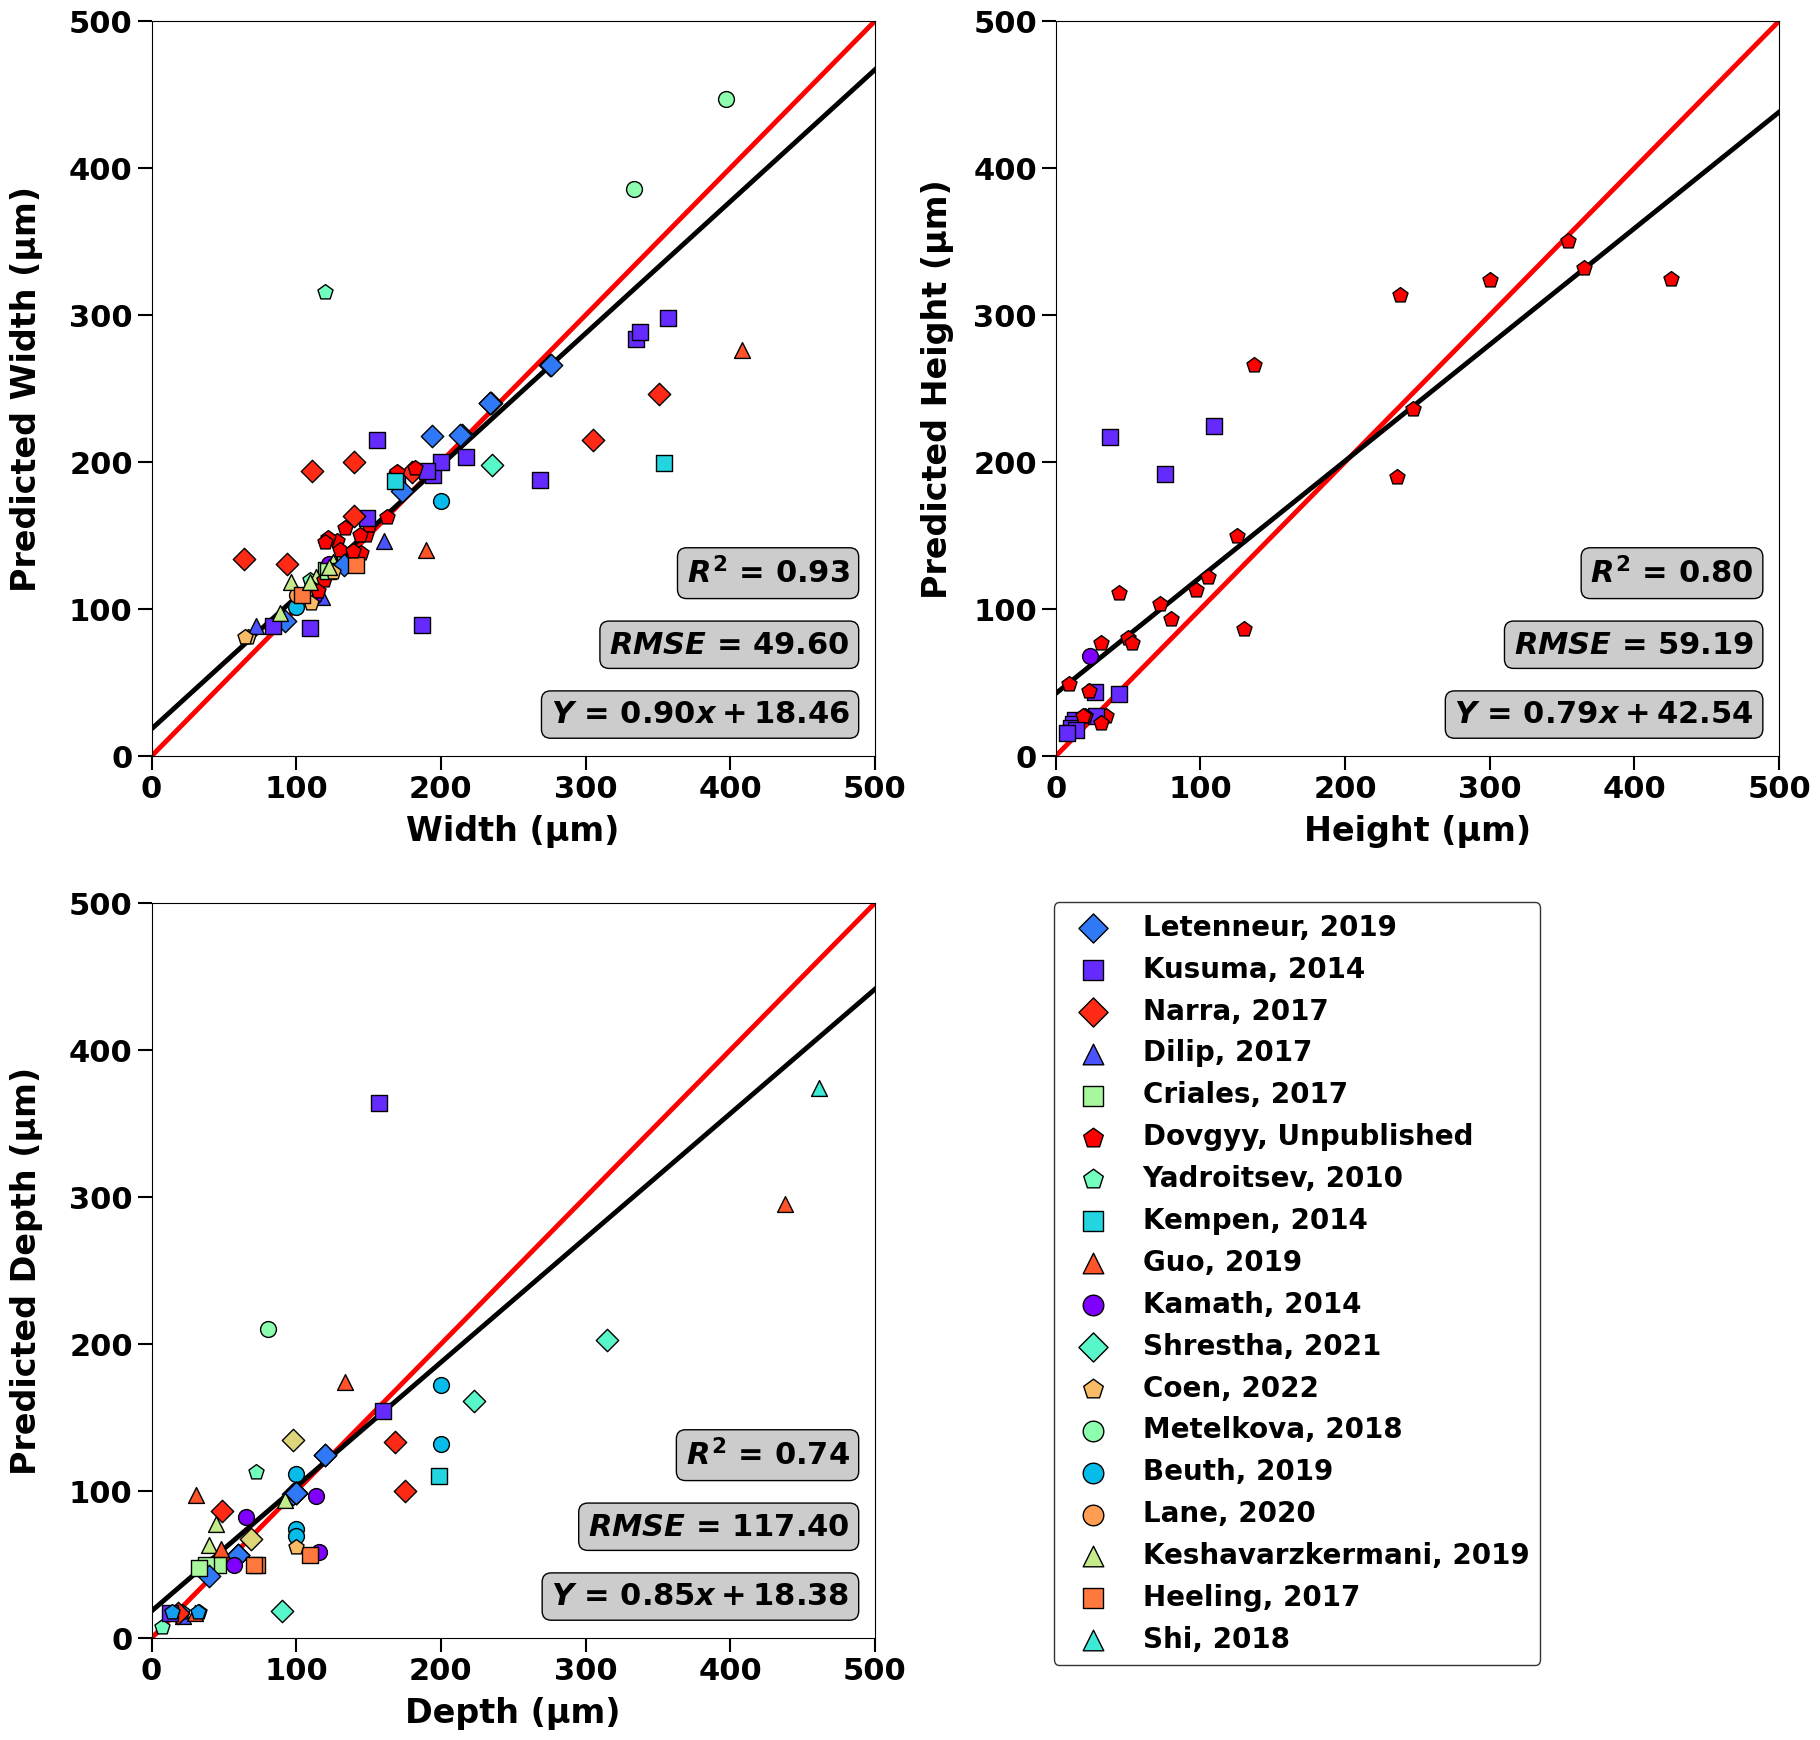

In [58]:
plot_perf()

# ElasticNet

In [74]:
# https://stats.stackexchange.com/questions/93181/ridge-lasso-and-elastic-net
# Use Elasticnet because we want to balance between L1 and L2 penalties when dealing with correlated predictiors and feature selection is wanted 

In [59]:
def objective(trial, x, y, cv, scoring):

    param = {
        "alpha": trial.suggest_float("alpha", 0.0001, 1.0, log=True),
        "l1_ratio": trial.suggest_float("l1_ratio", 0.0, 1.0),
        "tol": trial.suggest_float("alpha", 0.0001, 1.0, log=True),
        "max_iter": 10000
    }

    model = ElasticNet(**param, random_state=seed)
    cv_score = cross_val_score(model, x, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    return abs(np.mean(cv_score))

In [76]:
# Delete previous studies
optuna.delete_study(study_name="ElasticNet_width", storage="sqlite:///db.sqlite3")
optuna.delete_study(study_name="ElasticNet_height", storage="sqlite:///db.sqlite3")
optuna.delete_study(study_name="ElasticNet_depth", storage="sqlite:///db.sqlite3")

In [60]:
%%capture capt
study_width = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="ElasticNet_width")
study_height = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="ElasticNet_height")
study_depth = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="ElasticNet_depth")
studies = [study_width, study_height, study_depth]

# Splitter object for K-fold CV
kfold = KFold(n_splits = 5, shuffle=True, random_state=seed)
# Pass additional arguments inside another function to avoid errors
# https://www.kaggle.com/code/bextuychiev/no-bs-guide-to-hyperparameter-tuning-with-optuna
func = lambda trial: objective(trial, x, y, cv=kfold, scoring="neg_root_mean_squared_error")
# func = lambda trial: objective(trial, x, y, cv=kfold, scoring="r2")
for i,data in enumerate(train_scaled):
    x = data[0]
    y = data[1]

    studies[i].optimize(func, n_trials=100)

[I 2024-07-18 12:38:43,435] A new study created in RDB with name: ElasticNet_width


[I 2024-07-18 12:38:43,525] A new study created in RDB with name: ElasticNet_height
[I 2024-07-18 12:38:43,655] A new study created in RDB with name: ElasticNet_depth
[I 2024-07-18 12:38:43,811] Trial 0 finished with value: 84.74942932300101 and parameters: {'alpha': 0.013430489119414739, 'l1_ratio': 0.99768230221253}. Best is trial 0 with value: 84.74942932300101.
[I 2024-07-18 12:38:43,903] Trial 1 finished with value: 84.69232438808277 and parameters: {'alpha': 0.010324413250089067, 'l1_ratio': 0.21138890726623416}. Best is trial 1 with value: 84.69232438808277.
[I 2024-07-18 12:38:44,007] Trial 2 finished with value: 84.7506095530334 and parameters: {'alpha': 0.0002649880292958107, 'l1_ratio': 0.29667470063714674}. Best is trial 1 with value: 84.69232438808277.
[I 2024-07-18 12:38:44,070] Trial 3 finished with value: 101.45461741311952 and parameters: {'alpha': 0.6618568844859537, 'l1_ratio': 0.06351954553829098}. Best is trial 1 with value: 84.69232438808277.
[I 2024-07-18 12:38:4

In [ ]:
# http://localhost:8080/dashboard
!optuna-dashboard sqlite:///db.sqlite3b

In [61]:
# Save parameters to excel
for i, study in enumerate(studies):
    trials_df = study.trials_dataframe()
    trials_df.to_excel(f"/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Melt Pool Models/ElasticNet/ElasticNet_{i:02d}.xlsx")

    with open(f'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Melt Pool Models/ElasticNet/ElasticNet_best_params_{i:02d}.json', 'w+') as f:
        json.dump(study.best_params, f)
    with open(f'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Melt Pool Models/ElasticNet/ElasticNet_best_value_{i:02d}.json', 'w+') as f:
        json.dump(study.best_value, f)

In [62]:
# Train with best hyperparameters
hyp_params = []
for i, study in enumerate(studies):
    path = f'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Melt Pool Models/ElasticNet/ElasticNet_best_params_{i:02d}.json'
    with open(path, "r") as f:
        hyp_params.append(json.load(f))

In [63]:
models = []
predictions = []
for i,data in enumerate(train_scaled):
    x = data[0]
    y = data[1]

    model = ElasticNet(**hyp_params[i])
    model.fit(x, y)
    predictions.append((model.predict(test_scaled[i][0])))
    models.append(model)

/var/folders/dr/88_11bqj7nv1y6zj8hs35g3m0000gp/T/ipykernel_22693/364832982.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow', list_length)


Width (μm)
Mean squared error, RMSE = 101.57
Coefficient of determination, r2 = 0.70
Height (μm)
Mean squared error, RMSE = 92.94
Coefficient of determination, r2 = 0.50
Depth (μm)
Mean squared error, RMSE = 149.90
Coefficient of determination, r2 = 0.58


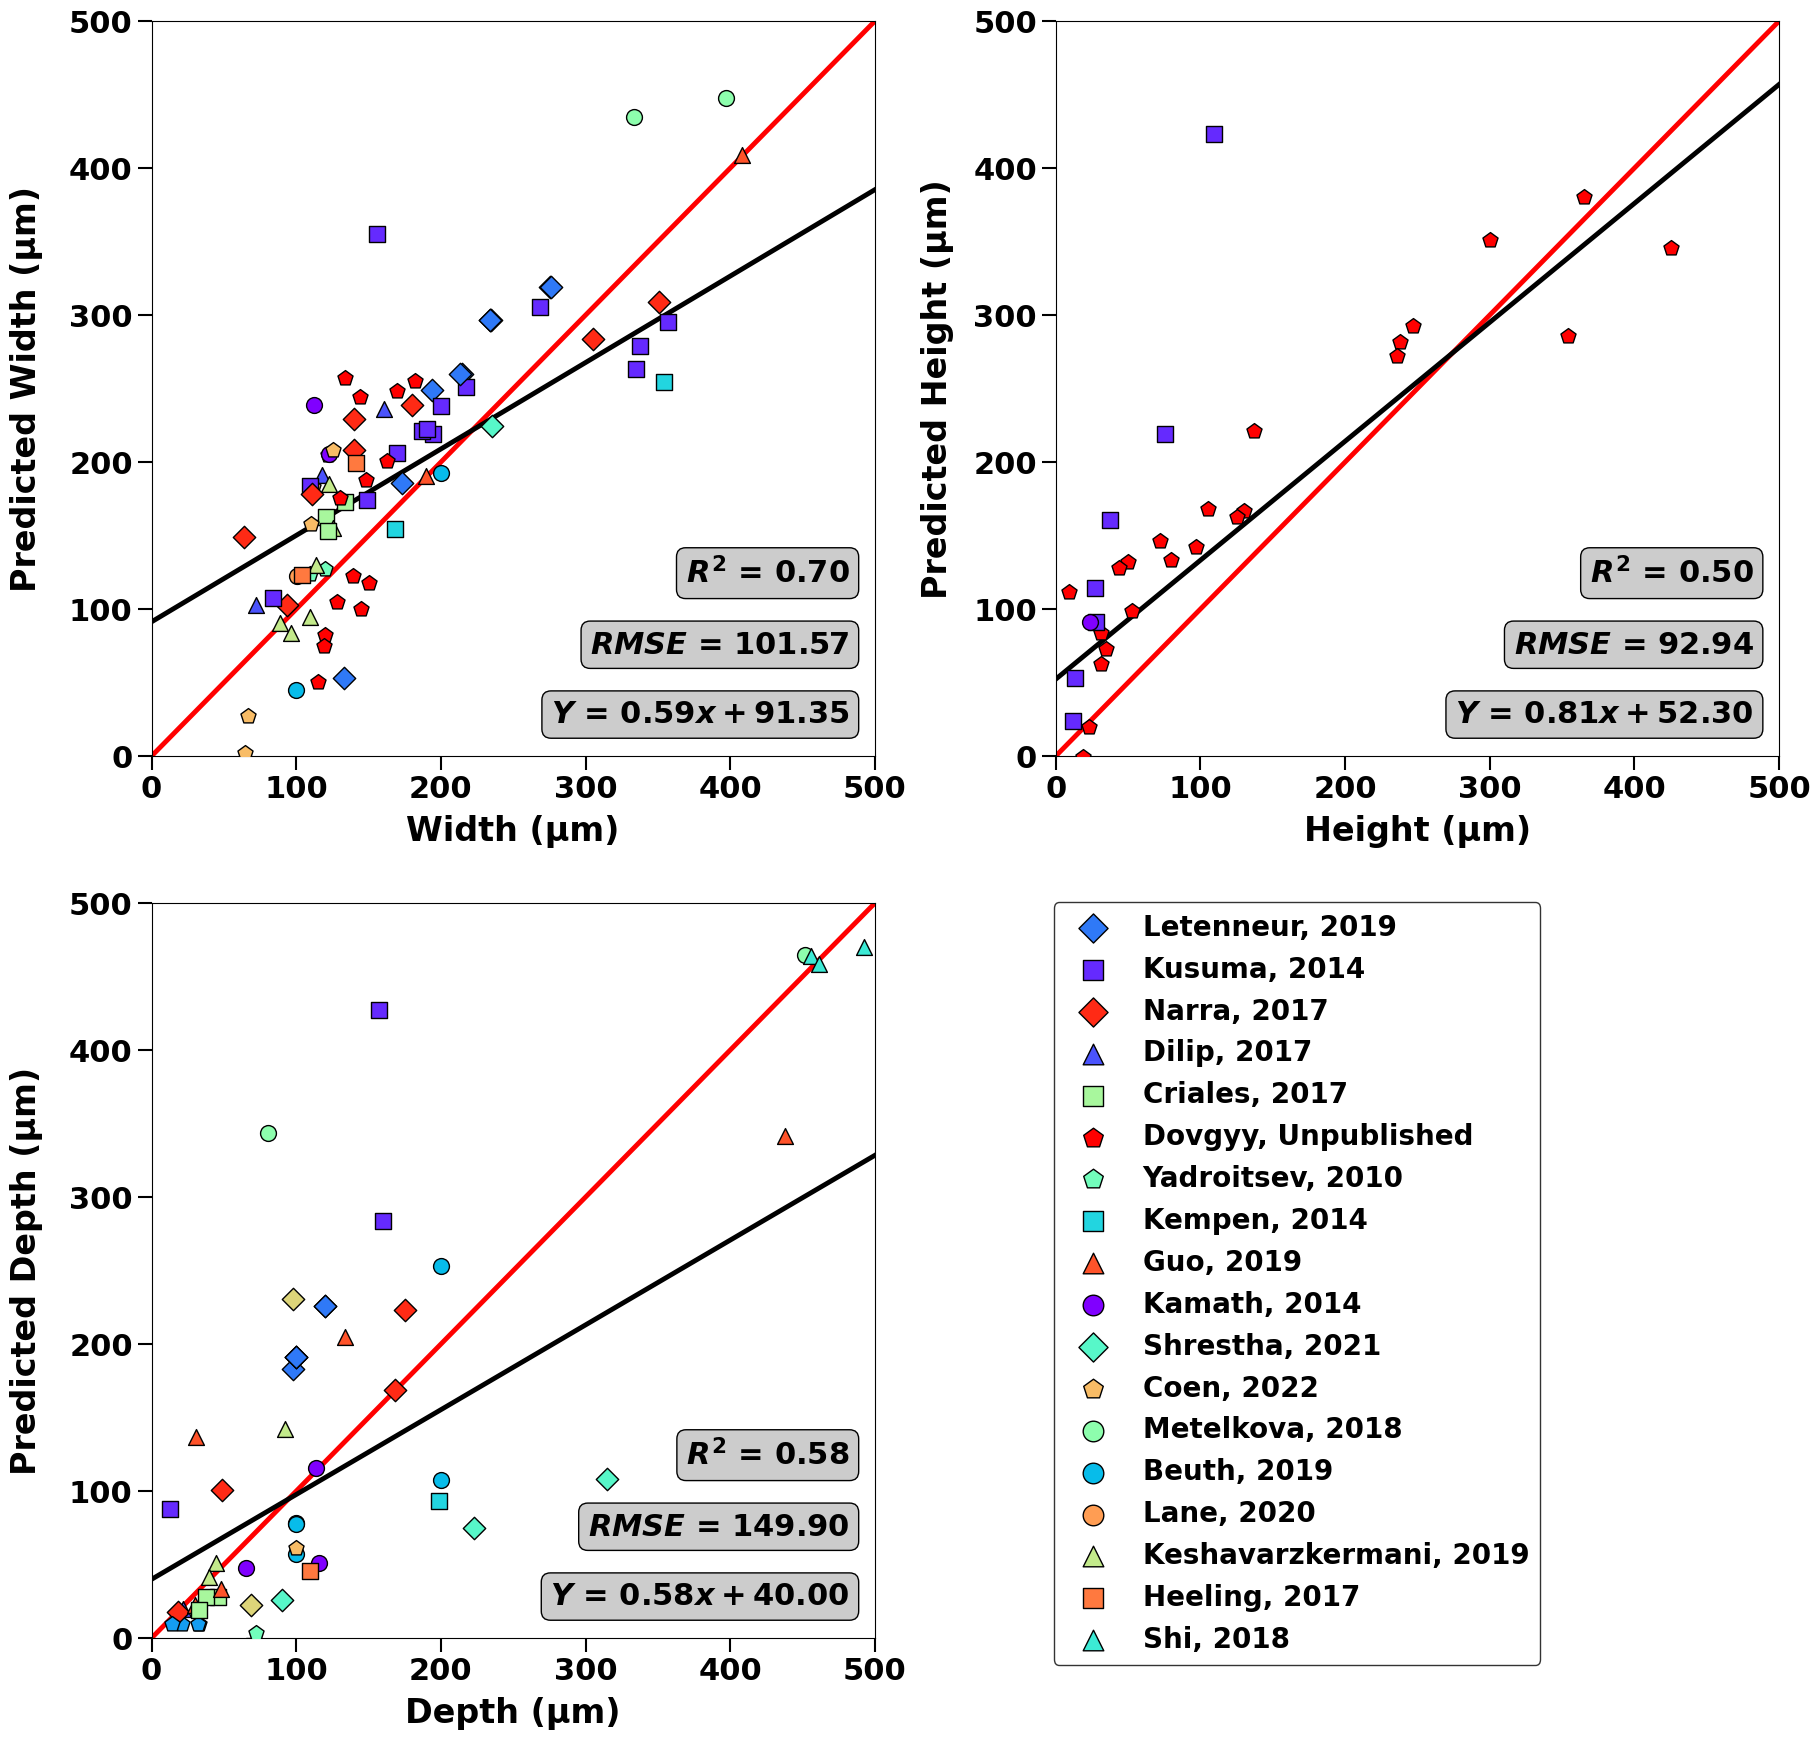

In [64]:
plot_perf()

# Final Melt Pool Dimension Prediction

In [14]:
# Choose materials and features input and outputs
materials_list = ['316L', 'IN718', 'TI6Al4V', 'AlSi10Mg']
input_var = ['Material',
             'Laser Power (W)',
             'Scanning Speed (mm/s)']

path = r'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Process Parameters and Properties LPBF - New.xlsx'
path = r'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Melt Pool Models/x_data.xlsx'

original_df = pd.read_excel(path)
original_df = original_df[input_var]
original_df.dropna(inplace=True)
# Store original material list to standardise data
original_mat = original_df['Material'].reset_index(drop=True).tolist()
original_df = original_df.drop(columns='Material').reset_index(drop=True)
original_df

Laser Power (W)  Scanning Speed (mm/s)
0               110.0                  600.0
1               110.0                  400.0
2               120.0                  400.0
3               130.0                  400.0
4               180.0                  600.0
...               ...                    ...
2592            350.0                 1700.0
2593            100.0                 1700.0
2594            200.0                 1700.0
2595            350.0                 1400.0
2596            350.0                 2000.0

[2597 rows x 2 columns]

In [15]:
# Standardise data
original_df = Standardizer_Func(data=original_df, features_list=original_df.columns.tolist())
original_df

Laser Power (W)  Scanning Speed (mm/s)
0           -0.804490              -0.519107
1           -0.804490              -0.900601
2           -0.745338              -0.900601
3           -0.686187              -0.900601
4           -0.390430              -0.519107
...               ...                    ...
2592         0.615143               1.579112
2593        -0.863641               1.579112
2594        -0.272128               1.579112
2595         0.615143               1.006871
2596         0.615143               2.151354

[2597 rows x 2 columns]

In [16]:
material_col = test_scaled[0][0].columns.tolist()
material_col.remove('Laser Power (W)')
material_col.remove('Scanning Speed (mm/s)')

# Add trained data columns to original data
for col in material_col:
    if col not in original_df.columns:
        original_df[col] = 0

original_df

Laser Power (W)  Scanning Speed (mm/s)  316L  718LC  904l  AlSi10Mg  \
0           -0.804490              -0.519107     0      0     0         0   
1           -0.804490              -0.900601     0      0     0         0   
2           -0.745338              -0.900601     0      0     0         0   
3           -0.686187              -0.900601     0      0     0         0   
4           -0.390430              -0.519107     0      0     0         0   
...               ...                    ...   ...    ...   ...       ...   
2592         0.615143               1.579112     0      0     0         0   
2593        -0.863641               1.579112     0      0     0         0   
2594        -0.272128               1.579112     0      0     0         0   
2595         0.615143               1.006871     0      0     0         0   
2596         0.615143               2.151354     0      0     0         0   

      CP Ti  Hastelloy X  IN625  IN718  Ti6Al4V  
0         0            0      0      0        0  
1         0            0      0      0        0  
2         0            0      0      0        0  
3         0            0      0      0        0  
4         0            0      0      0        0  
...     ...          ...    ...    ...      ...  
2592      0            0      0      0        0  
2593      0            0      0      0        0  
2594      0            0      0      0        0  
2595      0            0      0      0        0  
2596      0            0      0      0        0  

[2597 rows x 11 columns]

In [17]:
# Place original material into the correct columns
for index, mat in enumerate(original_mat):
    if mat in original_df.columns:
        original_df.at[index, mat] = 1
original_df

Laser Power (W)  Scanning Speed (mm/s)  316L  718LC  904l  AlSi10Mg  \
0           -0.804490              -0.519107     0      0     0         0   
1           -0.804490              -0.900601     0      0     0         0   
2           -0.745338              -0.900601     0      0     0         0   
3           -0.686187              -0.900601     0      0     0         0   
4           -0.390430              -0.519107     0      0     0         0   
...               ...                    ...   ...    ...   ...       ...   
2592         0.615143               1.579112     1      0     0         0   
2593        -0.863641               1.579112     1      0     0         0   
2594        -0.272128               1.579112     1      0     0         0   
2595         0.615143               1.006871     1      0     0         0   
2596         0.615143               2.151354     1      0     0         0   

      CP Ti  Hastelloy X  IN625  IN718  Ti6Al4V  
0         0            0      0      1        0  
1         0            0      0      1        0  
2         0            0      0      1        0  
3         0            0      0      1        0  
4         0            0      0      1        0  
...     ...          ...    ...    ...      ...  
2592      0            0      0      0        0  
2593      0            0      0      0        0  
2594      0            0      0      0        0  
2595      0            0      0      0        0  
2596      0            0      0      0        0  

[2597 rows x 11 columns]

In [20]:
# Train with best hyperparameters
hyp_params = []
study_width = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="NN_width")
study_height = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="NN_height")
study_depth = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="NN_depth")
studies = [study_width, study_height, study_depth]

for i, study in enumerate(studies):
    path = f'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Melt Pool Models/Neural Network/NeuralNetwork_best_params_{i:02d}.json'
    with open(path, "r") as f:
        hyp_params.append(json.load(f))

[I 2024-07-29 14:48:11,084] Using an existing study with name 'NN_width' instead of creating a new one.
[I 2024-07-29 14:48:11,117] Using an existing study with name 'NN_height' instead of creating a new one.
[I 2024-07-29 14:48:11,138] Using an existing study with name 'NN_depth' instead of creating a new one.


In [21]:
models = []
predictions = []
for i, data in enumerate(train_scaled):
    x = data[0]
    y = data[1]

    params = hyp_params[i]
    hidden_layer_sizes = tuple(params[f"neurons_layer_{j+1}"] for j in range(params["n_layers"]))

    model = MLPRegressor(
        hidden_layer_sizes=hidden_layer_sizes,
        learning_rate_init=params["learning_rate_init"],
        solver="adam",
        activation=params["activation"],
        random_state=seed,
        max_iter=2000
    )
    
    model.fit(x, y)
    predictions.append(model.predict(original_df))
    models.append(model)

/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1624: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1624: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1624: DataConversionWarning: 

In [23]:
data[0]

Laser Power (W)  Scanning Speed (mm/s)  316L  718LC  904l  AlSi10Mg  \
270        -1.009506              -0.934574   1.0    0.0   0.0       0.0   
186        -0.256016               0.092968   0.0    0.0   0.0       1.0   
119         2.757943              -1.191460   1.0    0.0   0.0       0.0   
184         1.024916              -0.249546   0.0    0.0   0.0       1.0   
100         1.250963              -0.977388   0.0    0.0   0.0       0.0   
..               ...                    ...   ...    ...   ...       ...   
250        -1.009506              -0.934574   1.0    0.0   0.0       0.0   
96          1.250963              -1.148645   0.0    0.0   0.0       0.0   
131         1.250963              -0.848946   1.0    0.0   0.0       0.0   
476         0.120729              -0.934574   0.0    0.0   0.0       0.0   
127         1.250963              -1.191460   1.0    0.0   0.0       0.0   

     CP Ti  Hastelloy X  IN625  IN718  Ti6Al4V  
270    0.0          0.0    0.0    0.0      0.0  
186    0.0          0.0    0.0    0.0      0.0  
119    0.0          0.0    0.0    0.0      0.0  
184    0.0          0.0    0.0    0.0      0.0  
100    0.0          0.0    0.0    0.0      1.0  
..     ...          ...    ...    ...      ...  
250    0.0          0.0    0.0    0.0      0.0  
96     0.0          0.0    0.0    0.0      1.0  
131    0.0          0.0    0.0    0.0      0.0  
476    0.0          0.0    0.0    1.0      0.0  
127    0.0          0.0    0.0    0.0      0.0  

[252 rows x 11 columns]

In [22]:
# Save Models
import joblib

# Save each model in the list
for i, model in enumerate(models):
    filename = f'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Melt Pool Models/model_{i}.joblib'
    joblib.dump(model, filename)

In [215]:
columns = ['Width (um)', 'Height (um)', 'Depth (um)']
meltpool_df = pd.DataFrame(predictions).transpose()
# meltpool_df = pd.DataFrame(meltpool_df, columns=columns)
meltpool_df.columns = [col_name for col_name in columns]
meltpool_df

Width (um)  Height (um)  Depth (um)
0     143.055499   105.437550  148.570219
1     172.199533   180.409807  245.793047
2     174.389234   190.272927  254.169522
3     176.577597   200.809048  265.876928
4     160.234253   149.868656  191.320225
...          ...          ...         ...
2592   93.133548    79.510408   88.595636
2593   65.286757    24.616853   45.018364
2594   88.097775    45.682630   62.844338
2595  105.149887    74.895598  119.767688
2596   99.097713    57.854626   87.895423

[2597 rows x 3 columns]

In [ ]:
# Export melt pool predictions to excel
# meltpool_df.to_excel('/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Melt Pool Models/MeltPoolPredictions.xlsx')